In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt


In [ ]:
df = pd.read_csv('E:/UIT/Nam-2/Ki-2/Predicting-Popularity-of-Vietnamese-Articles/2. Data Pre-processing/dataset3.csv')

In [ ]:
df['popularity_score'] = (0.1 * df['comments'] + 0.1 * df['interactions'] ) / (df['time_since_posted'] + 1e-10)
df.drop(columns=['time_since_posted'], inplace=True)

In [ ]:
df.columns

Index(['title', 'date', 'wordcount', 'comments', 'interactions', 'images',
       'videos', 'tags', 'category', 'popularity_score', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday',
       'classified_tags', 'has_famous_people_tag', 'has_place_tag',
       'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions'],
      dtype='object')

In [ ]:
num_cols = ['wordcount', 'images', 'title_length',
       'videos', 'title_score', 'sentiment_score', 'positive', 'negative', 'neutral','popularity_score']

In [ ]:
cat_cols = ['has_number', 'has_emotion', 'is_question',
            'posted_hour','is_weekday', 'has_famous_people_tag',
            'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
            'has_interactions','popularity_score' ]

In [ ]:
df_num = df[num_cols].copy()

In [ ]:
df_cat = df[cat_cols].copy()

In [ ]:
X_num = df_num.drop(columns = 'popularity_score')
y_num = df_num['popularity_score']

Filter-based(Tr∆∞·ªõc encode): Correlation Coefficient, Mutual Info
Embeddef-based(Sau khi encode): Feature Importance

###Correlation Coefficient (Pearson)###

T∆∞∆°ng quan Pearson v·ªõi bi·∫øn m·ª•c ti√™u:
 title_score        0.356939
negative           0.102101
wordcount          0.072940
images             0.050012
videos             0.039533
title_length       0.029952
neutral           -0.022716
positive          -0.084943
sentiment_score   -0.106390
Name: popularity_score, dtype: float64


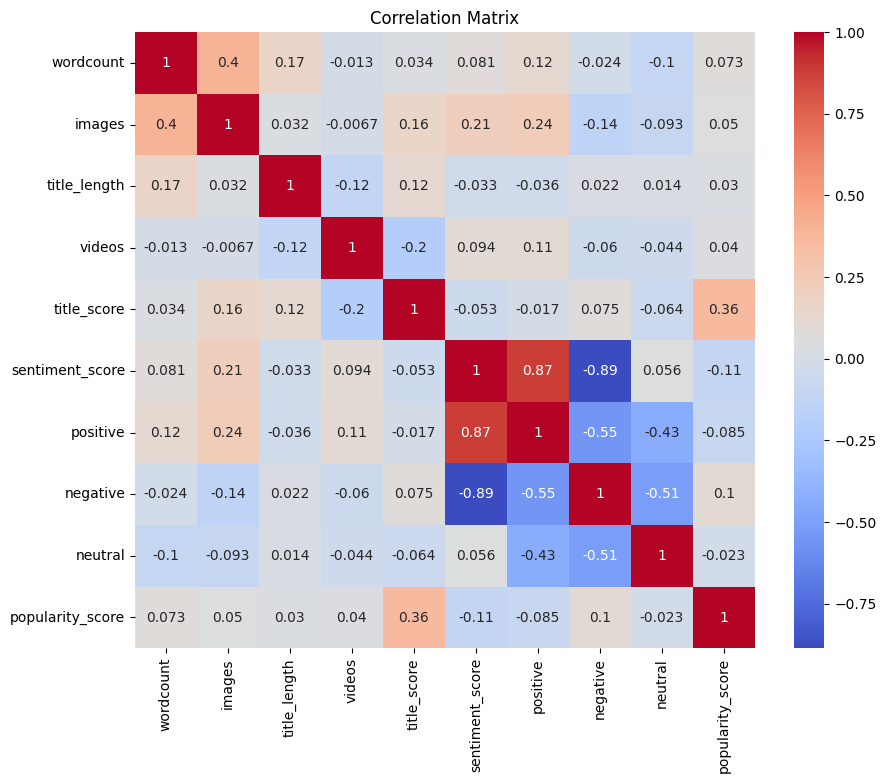

In [ ]:
# T√≠nh t∆∞∆°ng quan v·ªõi bi·∫øn m·ª•c ti√™u
X_num['popularity_score'] = y_num
corr_with_target = X_num.corr()['popularity_score'].drop('popularity_score')

# In ra t∆∞∆°ng quan
print("T∆∞∆°ng quan Pearson v·ªõi bi·∫øn m·ª•c ti√™u:\n", corr_with_target.sort_values(ascending=False))

# V·∫Ω heatmap cho ma tr·∫≠n t∆∞∆°ng quan
plt.figure(figsize=(10, 8))
sns.heatmap(X_num.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df = df.drop(columns = 'positive')

### Code x·ª≠ l√Ω tags

In [ ]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_dev, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [ ]:

# Normalize tag: replace spaces with underscores
def normalize_tag(tag: str) -> str:
    return tag.replace(' ', '_')

# Create tag_text for each set
def tags_to_doc(cat_dict, frequent_tag_set=None):
    if frequent_tag_set:
        return ' '.join(
            normalize_tag(tag)
            for tags in cat_dict.values()
            for tag in tags
            if normalize_tag(tag) in frequent_tag_set
        )
    return ' '.join(
        normalize_tag(tag)
        for tags in cat_dict.values()
        for tag in tags
    )

# Safe evaluation of string to dictionary
def safe_eval(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return {}
    return {}

In [ ]:
# Apply safe_eval to classified_tags
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
df_dev['classified_tags'] = df_dev['classified_tags'].apply(safe_eval)
df_test['classified_tags'] = df_test['classified_tags'].apply(safe_eval)

# 1. Find frequent tags only on train set
all_tags_train = []
for row in df_train['classified_tags']:
    for tags in row.values():
        all_tags_train.extend([normalize_tag(tag) for tag in tags])

k = 5
tag_counts = Counter(all_tags_train)
frequent_tags = [tag for tag, count in tag_counts.items() if count >= k]
frequent_tags_set = set(frequent_tags)

In [ ]:
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
print(df_train['classified_tags'].map(type).value_counts())

classified_tags
<class 'dict'>    3717
Name: count, dtype: int64


In [ ]:
# 2. Create tag_text for train/dev/test, keeping only frequent tags
df_train['tag_text'] = df_train['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_dev['tag_text'] = df_dev['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_test['tag_text'] = df_test['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))

# 3. Fit TF-IDF on train and transform on dev/test
vectorizer = TfidfVectorizer(vocabulary=frequent_tags)
X_train_tfidf = vectorizer.fit_transform(df_train['tag_text'])
X_dev_tfidf = vectorizer.transform(df_dev['tag_text'])
X_test_tfidf = vectorizer.transform(df_test['tag_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### One hot + Standard_Scaled

In [ ]:
y_train = df_train['popularity_score']
X_train = df_train.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_test = df_test['popularity_score']
X_test = df_test.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_dev = df_dev['popularity_score']
X_dev = df_dev.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

In [ ]:
categorical_cols = ['category', 'posted_hour', 'has_comments', 'has_interactions', 'has_number',
                   'has_emotion', 'is_question','has_famous_people_tag', 'has_place_tag', 'has_event_tag',
                   'has_org_tag', 'is_weekday'
    ]

# Lo·∫°i tr·ª´ c√°c c·ªôt cols_to_exclude ra kh·ªèi t·∫≠p chu·∫©n h√≥a
X_train_to_scale = X_train.drop(columns=categorical_cols)
X_dev_to_scale = X_dev.drop(columns=categorical_cols)
X_test_to_scale = X_test.drop(columns=categorical_cols)

# Chu·∫©n h√≥a
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_to_scale),
                             columns=X_train_to_scale.columns,
                             index=X_train_to_scale.index)
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev_to_scale),
                           columns=X_dev_to_scale.columns,
                           index=X_dev_to_scale.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_to_scale),
                            columns=X_test_to_scale.columns,
                            index=X_test_to_scale.index)

# G·ªôp l·∫°i v·ªõi c√°c c·ªôt ƒë√£ lo·∫°i tr·ª´
X_train_scaled = pd.concat([X_train_scaled, X_train[categorical_cols]], axis=1)
X_dev_scaled = pd.concat([X_dev_scaled, X_dev[categorical_cols]], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[categorical_cols]], axis=1)

In [ ]:
print("Columns in X_train:", X_train.columns.tolist())
print("Columns in X_dev:", X_dev.columns.tolist())
print("Columns in X_test:", X_test.columns.tolist())
print("Columns in X_train_scaled:", X_train_scaled.columns.tolist())
print("Columns in X_dev_scaled:", X_dev_scaled.columns.tolist())
print("Columns in X_test_scaled:", X_test_scaled.columns.tolist())

if categorical_cols:
    print("C·ªôt ph√¢n lo·∫°i c·∫ßn m√£ h√≥a:", categorical_cols)
    # T·∫°o OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # M√£ h√≥a c·ªôt ph√¢n lo·∫°i cho train
    categorical_encoded = onehot_encoder.fit_transform(X_train_scaled[categorical_cols])
    categorical_columns = onehot_encoder.get_feature_names_out(categorical_cols)
    categorical_df = pd.DataFrame(categorical_encoded, columns=categorical_columns, index=X_train_scaled.index)

    # Lo·∫°i b·ªè c·ªôt ph√¢n lo·∫°i g·ªëc v√† g·ªôp v·ªõi d·ªØ li·ªáu m√£ h√≥a
    X_train_scaled = X_train_scaled.drop(columns=categorical_cols, errors='ignore')
    X_train_scaled = pd.concat([X_train_scaled, categorical_df], axis=1)

    # T∆∞∆°ng t·ª± cho dev
    categorical_encoded_dev = onehot_encoder.transform(X_dev_scaled[categorical_cols])
    categorical_df_dev = pd.DataFrame(categorical_encoded_dev, columns=categorical_columns, index=X_dev_scaled.index)
    X_dev_scaled = X_dev_scaled.drop(columns=categorical_cols, errors='ignore')
    X_dev_scaled = pd.concat([X_dev_scaled, categorical_df_dev], axis=1)

    # T∆∞∆°ng t·ª± cho test
    categorical_encoded_test = onehot_encoder.transform(X_test_scaled[categorical_cols])
    categorical_df_test = pd.DataFrame(categorical_encoded_test, columns=categorical_columns, index=X_test_scaled.index)
    X_test_scaled = X_test_scaled.drop(columns=categorical_cols, errors='ignore')
    X_test_scaled = pd.concat([X_test_scaled, categorical_df_test], axis=1)
else:
    print("Kh√¥ng c√≥ c·ªôt ph√¢n lo·∫°i c·∫ßn m√£ h√≥a.")

# Ki·ªÉm tra shape sau khi m√£ h√≥a
print("Shape X_train_scaled:", X_train_scaled.shape)
print("Shape X_dev_scaled:", X_dev_scaled.shape)
print("Shape X_test_scaled:", X_test_scaled.shape)

Columns in X_train: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_dev: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_test: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_train_scaled: ['wordcoun

In [ ]:
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Chuy·ªÉn ƒë·ªïi DataFrame th√†nh sparse matrix
X_train_scaled_transform = X_train_scaled.apply(pd.to_numeric)
X_dev_scaled_transform = X_dev_scaled.apply(pd.to_numeric)
X_test_scaled_transform = X_test_scaled.apply(pd.to_numeric)

X_train_scaled_sparse = csr_matrix(X_train_scaled_transform.values)
X_dev_scaled_sparse = csr_matrix(X_dev_scaled_transform.values)
X_test_scaled_sparse = csr_matrix(X_test_scaled_transform.values)

# K·∫øt h·ª£p d·ªØ li·ªáu
X_train_combined = hstack([X_train_tfidf, X_train_scaled_sparse])
X_dev_combined = hstack([X_dev_tfidf, X_dev_scaled_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_scaled_sparse])

# In th√¥ng tin ƒë·ªÉ ki·ªÉm tra
print("Shape c·ªßa X_train_combined:", X_train_combined.shape)
print("Shape c·ªßa X_dev_combined:", X_dev_combined.shape)
print("Shape c·ªßa X_test_combined:", X_test_combined.shape)

Shape c·ªßa X_train_combined: (3717, 437)
Shape c·ªßa X_dev_combined: (796, 437)
Shape c·ªßa X_test_combined: (797, 437)


### Ch·ªâ th·ª±c hi·ªán MI tr√™n t·∫≠p scaled v√† ch∆∞a transform th√†nh matrix

In [ ]:
# 11. T·∫°o feature_names
# existing_feature_names = X_train_scaled_transform.columns.tolist()
# tfidf_feature_names = [f'tfidf_{tag}' for tag in vectorizer.get_feature_names_out()]
feature_names = X_train_scaled.columns.tolist()

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
y_train = np.ravel(y_train)  # ƒê·∫£m b·∫£o y l√† 1D

selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Xem ƒëi·ªÉm MI
scores = pd.DataFrame({
    "ƒê·∫∑c tr∆∞ng": feature_names,
    "ƒêi·ªÉm MI": selector.scores_
}).sort_values(by="ƒêi·ªÉm MI", ascending=False)

In [ ]:
print("Top 5 ƒë·∫∑c tr∆∞ng theo MI:")
print(scores.head())

# L·∫•y t√™n c√°c ƒë·∫∑c tr∆∞ng ƒë∆∞·ª£c ch·ªçn
selected_features = np.array(feature_names)[selector.get_support()]
print("\nC√°c ƒë·∫∑c tr∆∞ng ƒë∆∞·ª£c ch·ªçn:", selected_features)

Top 5 ƒë·∫∑c tr∆∞ng theo MI:
             ƒê·∫∑c tr∆∞ng   ƒêi·ªÉm MI
44  has_interactions_1  0.520752
41      has_comments_0  0.515832
42      has_comments_1  0.504392
43  has_interactions_0  0.502469
4          title_score  0.128648

C√°c ƒë·∫∑c tr∆∞ng ƒë∆∞·ª£c ch·ªçn: ['wordcount' 'title_length' 'title_score' 'negative' 'category_1'
 'category_2' 'category_6' 'category_7' 'category_8' 'category_9'
 'posted_hour_6' 'posted_hour_16' 'has_comments_0' 'has_comments_1'
 'has_interactions_0' 'has_interactions_1' 'has_emotion_1'
 'has_event_tag_True' 'is_weekday_0' 'is_weekday_1']


In [ ]:
print("C√°c ƒë·∫∑c tr∆∞ng c√≥ ƒë·ªô d·ª± ƒëo√°n th·∫•p theo MI:")
print(scores.tail(20))

C√°c ƒë·∫∑c tr∆∞ng c√≥ ƒë·ªô d·ª± ƒëo√°n th·∫•p theo MI:
              ƒê·∫∑c tr∆∞ng   ƒêi·ªÉm MI
19        posted_hour_2  0.000397
5       sentiment_score  0.000000
1                images  0.000000
11           category_4  0.000000
28       posted_hour_11  0.000000
26        posted_hour_9  0.000000
25        posted_hour_8  0.000000
24        posted_hour_7  0.000000
17        posted_hour_0  0.000000
20        posted_hour_3  0.000000
7               neutral  0.000000
36       posted_hour_19  0.000000
29       posted_hour_12  0.000000
30       posted_hour_13  0.000000
35       posted_hour_18  0.000000
46         has_number_1  0.000000
50        is_question_1  0.000000
45         has_number_0  0.000000
55  has_event_tag_False  0.000000
53  has_place_tag_False  0.000000


In [ ]:
# Danh s√°ch c√°c c·ªôt c·∫ßn ki·ªÉm tra
cols_to_check = ['has_number_1', 'is_question_0', 'has_event_tag_False', 'neutral']

# Ki·ªÉm tra s·ªë gi√° tr·ªã duy nh·∫•t c·ªßa m·ªói bi·∫øn
print("üîç S·ªë gi√° tr·ªã duy nh·∫•t c·ªßa m·ªói bi·∫øn:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        unique_vals = X_train_scaled[col].nunique()
        print(f"{col}: {unique_vals} gi√° tr·ªã")
    else:
        print(f"‚ö†Ô∏è C·ªôt {col} kh√¥ng c√≥ trong X_train_scaled")

print("\n T·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa t·ª´ng gi√° tr·ªã:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        print(f"\nBi·∫øn: {col}")
        print(X_train_scaled[col].value_counts(dropna=False))


üîç S·ªë gi√° tr·ªã duy nh·∫•t c·ªßa m·ªói bi·∫øn:
has_number_1: 2 gi√° tr·ªã
is_question_0: 2 gi√° tr·ªã
has_event_tag_False: 2 gi√° tr·ªã
neutral: 3715 gi√° tr·ªã

 T·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa t·ª´ng gi√° tr·ªã:

Bi·∫øn: has_number_1
has_number_1
0.0    2583
1.0    1134
Name: count, dtype: int64

Bi·∫øn: is_question_0
is_question_0
1.0    3426
0.0     291
Name: count, dtype: int64

Bi·∫øn: has_event_tag_False
has_event_tag_False
1.0    3177
0.0     540
Name: count, dtype: int64

Bi·∫øn: neutral
neutral
 1.367053    2
 1.365384    2
-1.181051    1
-0.806657    1
 1.417916    1
            ..
 0.886918    1
-1.195000    1
-0.312870    1
-1.159529    1
-1.194622    1
Name: count, Length: 3715, dtype: int64


Kh√¥ng c·∫ßn thi·∫øt ph·∫£i x√≥a c√°c bi·∫øn n√†y do c√≥ nhi·ªÅu gi√° tr·ªã kh√°c nhau & ph√¢n b·ªë c·ªßa c√°c gi√° tr·ªã kh√¥ng qu√° l·ªách

### Feature Importance tr√™n t·∫≠p ch·ªâ c√≥ bi·∫øn ph√¢n lo·∫°i v√† s·ªë ##

In [ ]:
# Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# L·∫•y ƒëi·ªÉm t·∫ßm quan tr·ªçng
importances = rf.feature_importances_
feature_importance_rf = pd.DataFrame({
    'ƒê·∫∑c tr∆∞ng': feature_names,
    'T·∫ßm quan tr·ªçng': importances
})

In [ ]:
# Hi·ªÉn th·ªã top 5 ƒë·∫∑c tr∆∞ng
display("\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n", feature_importance_rf.sort_values(by='T·∫ßm quan tr·ªçng', ascending=False).tail(20))

'\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n'

ƒê·∫∑c tr∆∞ng  T·∫ßm quan tr·ªçng
58  has_org_tag_True        0.003001
50     is_question_1        0.002893
48     has_emotion_1        0.002870
22     posted_hour_5        0.002753
10        category_3        0.002662
35    posted_hour_18        0.002644
31    posted_hour_14        0.002631
12        category_5        0.002573
47     has_emotion_0        0.002533
40    posted_hour_23        0.002297
9         category_2        0.002207
49     is_question_0        0.001845
39    posted_hour_22        0.001813
21     posted_hour_4        0.001649
18     posted_hour_1        0.001168
16        category_9        0.000825
8         category_1        0.000586
19     posted_hour_2        0.000320
42    has_comments_1        0.000130
41    has_comments_0        0.000109

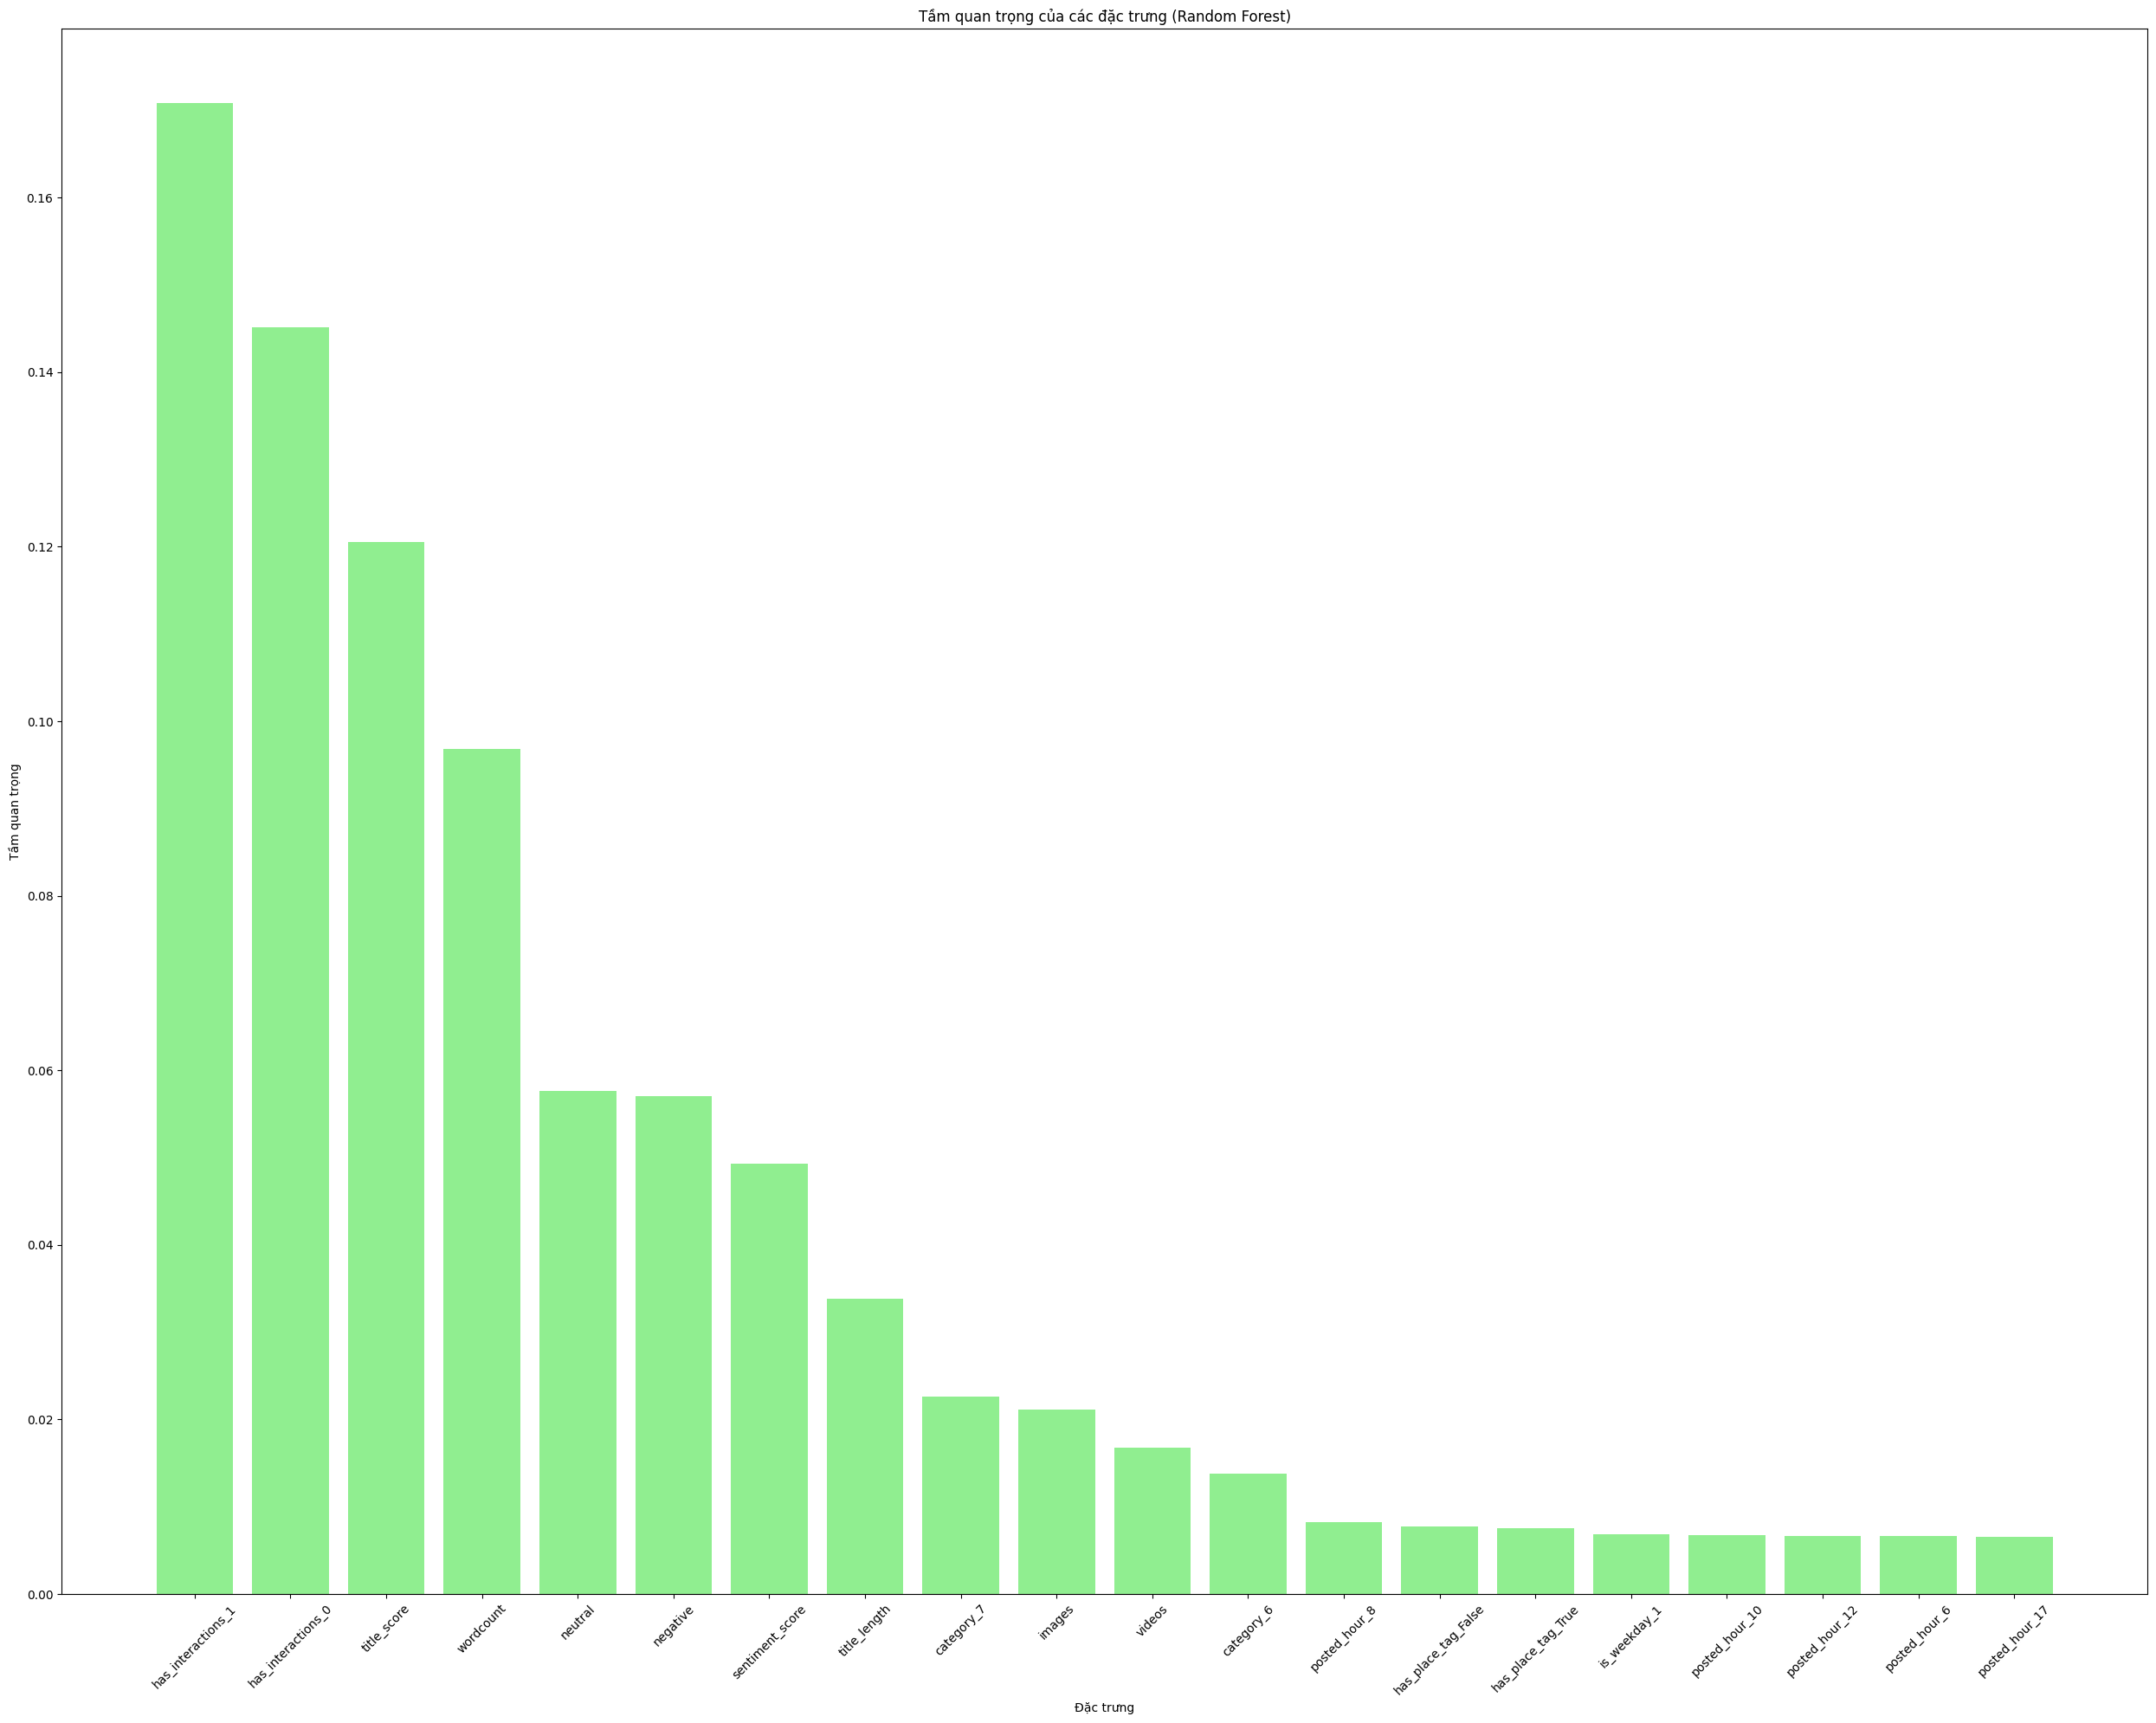

In [ ]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(25, 20))
top_rf = feature_importance_rf.sort_values(by='T·∫ßm quan tr·ªçng', ascending=False).head(20)
plt.bar(top_rf['ƒê·∫∑c tr∆∞ng'], top_rf['T·∫ßm quan tr·ªçng'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('ƒê·∫∑c tr∆∞ng')
plt.ylabel('T·∫ßm quan tr·ªçng')
plt.title('T·∫ßm quan tr·ªçng c·ªßa c√°c ƒë·∫∑c tr∆∞ng (Random Forest)')
plt.tight_layout()
plt.show()

### Feature Importance c√≥ bao g·ªìm c√°c TF-IDF Vector

In [ ]:
# 11. T·∫°o feature_names m·ªõi
existing_feature_names = X_train_scaled_transform.columns.tolist()
tfidf_feature_names = [f'tfidf_{tag}' for tag in vectorizer.get_feature_names_out()]
feature_names1 = existing_feature_names + tfidf_feature_names

In [ ]:
# Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train_combined, y_train)

# L·∫•y ƒëi·ªÉm t·∫ßm quan tr·ªçng
importances1 = rf1.feature_importances_
feature_importance_rf1 = pd.DataFrame({
    'ƒê·∫∑c tr∆∞ng': feature_names1,
    'T·∫ßm quan tr·ªçng': importances1
})

In [ ]:
# Hi·ªÉn th·ªã top 5 ƒë·∫∑c tr∆∞ng
display("\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n", feature_importance_rf1.sort_values(by='T·∫ßm quan tr·ªçng', ascending=False).tail(100))


'\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n'

ƒê·∫∑c tr∆∞ng  T·∫ßm quan tr·ªçng
42                     has_comments_1             0.0
36                     posted_hour_19             0.0
29                     posted_hour_12             0.0
140             tfidf_h·ªçc_ph√≠_ƒë·∫°i_h·ªçc             0.0
141          tfidf_Tuy·ªÉn_sinh_ƒë·∫°i_h·ªçc             0.0
..                                ...             ...
200  tfidf_L·ª´a_ƒë·∫£o_chi·∫øm_ƒëo·∫°t_t√†i_s·∫£n             0.0
201                   tfidf_H√≤a_Minzy             0.0
202                   tfidf_B·∫Øc_Bling             0.0
203                 tfidf_Sao_Hoa_ng·ªØ             0.0
223                      tfidf_SpaceX             0.0

[100 rows x 2 columns]

In [ ]:
# Hi·ªÉn th·ªã top 5 ƒë·∫∑c tr∆∞ng
display("\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n", feature_importance_rf1.sort_values(by='T·∫ßm quan tr·ªçng', ascending=False).head(10))

'\nT·∫ßm quan tr·ªçng c·ªßa ƒë·∫∑c tr∆∞ng (Random Forest):\n'

ƒê·∫∑c tr∆∞ng  T·∫ßm quan tr·ªçng
420  tfidf_ƒê·∫°i_h·ªçc_B√°ch_Khoa_TP_HCM        0.186752
419             tfidf_AI_Trung_Qu·ªëc        0.129218
380             tfidf_ƒêi·ªán_m·∫∑t_tr·ªùi        0.117017
376           tfidf_Carlo_Ancelotti        0.091493
383                       tfidf_S·ªüi        0.054266
382            tfidf_Ti·ªÉu_h√†nh_tinh        0.051394
381                    tfidf_Hacker        0.047218
379                   tfidf_b√°n_d·∫´n        0.032830
390                 tfidf_b·ªánh_th·∫≠n        0.022607
377                     tfidf_Tesla        0.021236

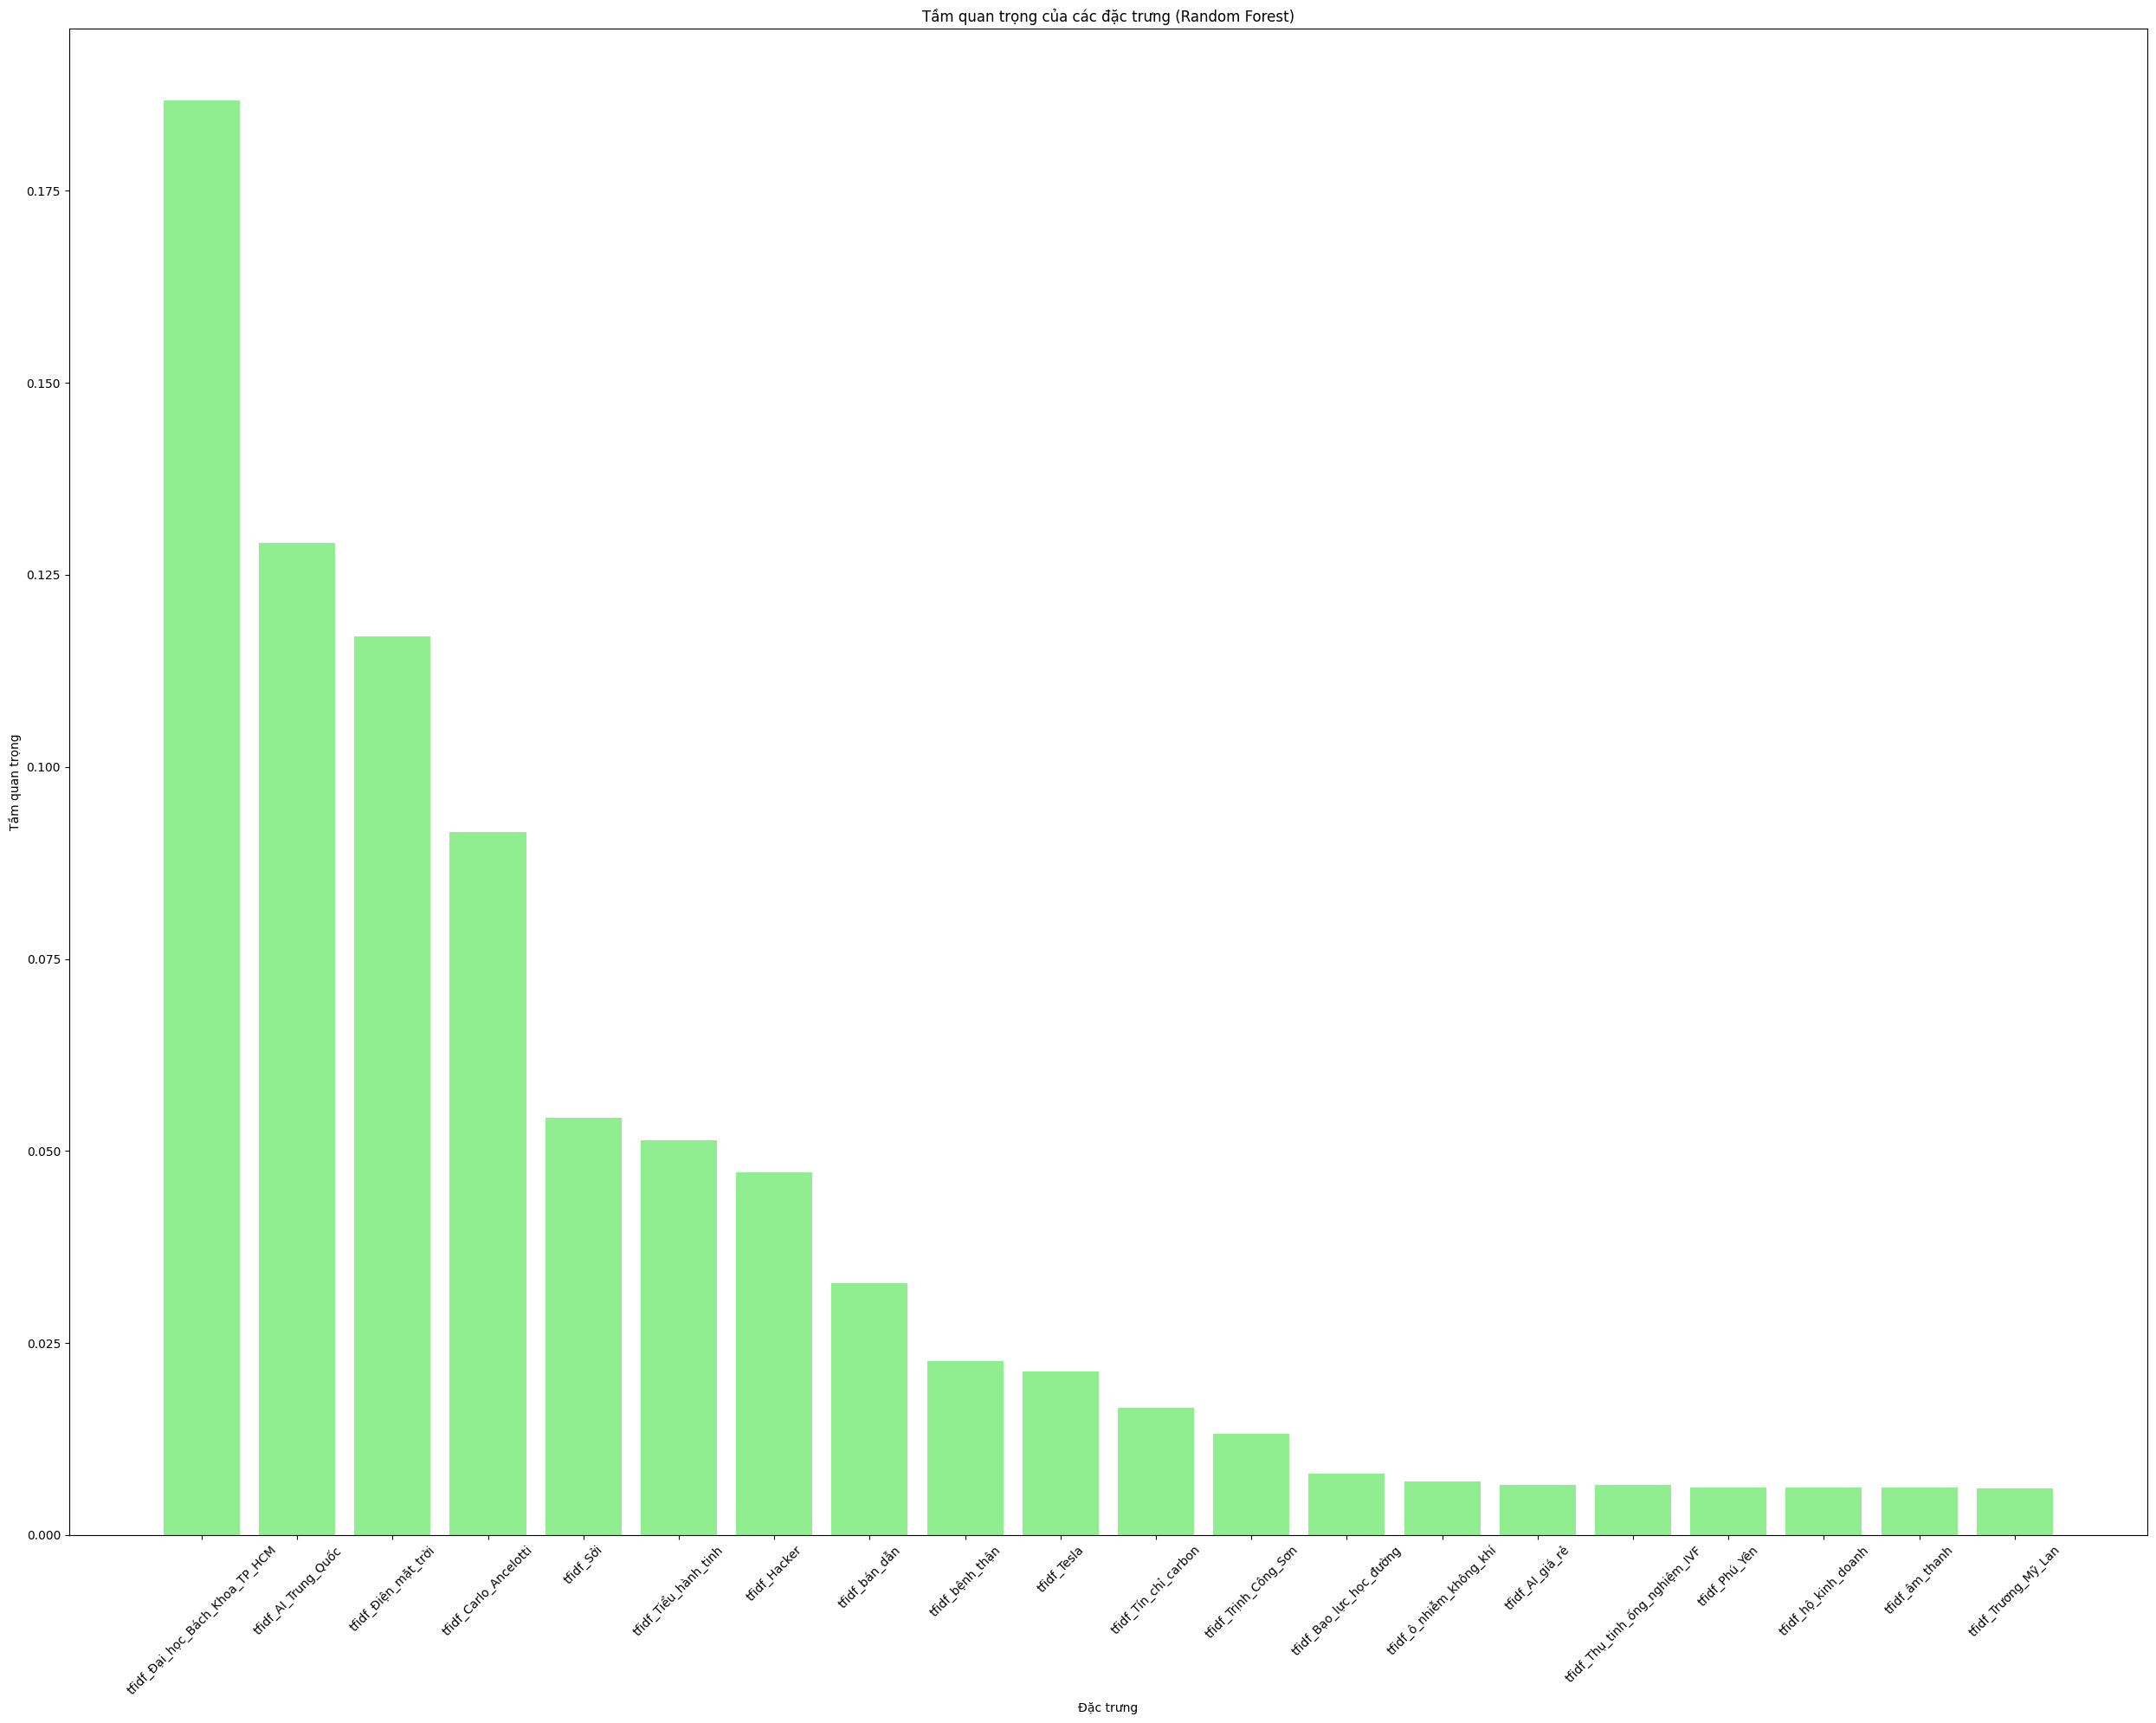

In [ ]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(25, 20))
top_rf = feature_importance_rf1.sort_values(by='T·∫ßm quan tr·ªçng', ascending=False).head(20)
plt.bar(top_rf['ƒê·∫∑c tr∆∞ng'], top_rf['T·∫ßm quan tr·ªçng'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('ƒê·∫∑c tr∆∞ng')
plt.ylabel('T·∫ßm quan tr·ªçng')
plt.title('T·∫ßm quan tr·ªçng c·ªßa c√°c ƒë·∫∑c tr∆∞ng (Random Forest)')
plt.tight_layout()
plt.show()

In [ ]:
low_fi_words = feature_importance_rf1[(feature_importance_rf1['T·∫ßm quan tr·ªçng'] == 0) & (feature_importance_rf1['ƒê·∫∑c tr∆∞ng'].str.startswith('tfidf_'))]['ƒê·∫∑c tr∆∞ng'].tolist()

print("T·ªïng s·ªë ƒë·∫∑c tr∆∞ng c√≥ FI = 0 trong TF-IDF:", len(low_fi_words))

T·ªïng s·ªë ƒë·∫∑c tr∆∞ng c√≥ FI = 0 trong TF-IDF: 230


In [ ]:
last_100 = low_fi_words[-100:]

In [ ]:
# Chuy·ªÉn t·ª´ sparse matrix sang DataFrame
X_train_df = pd.DataFrame(X_train_combined.toarray(), columns=feature_names1)
X_dev_df   = pd.DataFrame(X_dev_combined.toarray(),   columns=feature_names1)
X_test_df  = pd.DataFrame(X_test_combined.toarray(),  columns=feature_names1)

# X√≥a c√°c TF-IDF features kh√¥ng quan tr·ªçng
X_train_pruned = X_train_df.drop(columns=last_100)
X_dev_pruned   = X_dev_df.drop(columns=last_100)
X_test_pruned  = X_test_df.drop(columns=last_100)

In [ ]:
# In th√¥ng tin ƒë·ªÉ ki·ªÉm tra
print("Shape c·ªßa X_train_df:", X_train_df.shape)
print("Shape c·ªßa X_dev_df:", X_dev_df.shape)
print("Shape c·ªßa X_test_df:", X_test_df.shape)

# In th√¥ng tin ƒë·ªÉ ki·ªÉm tra
print("Shape c·ªßa X_train_pruned:", X_train_pruned.shape)
print("Shape c·ªßa X_dev_pruned:", X_dev_pruned.shape)
print("Shape c·ªßa X_test_pruned:", X_test_pruned.shape)

Shape c·ªßa X_train_df: (3717, 437)
Shape c·ªßa X_dev_df: (796, 437)
Shape c·ªßa X_test_df: (797, 437)
Shape c·ªßa X_train_pruned: (3717, 337)
Shape c·ªßa X_dev_pruned: (796, 337)
Shape c·ªßa X_test_pruned: (797, 337)


### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# T√≠nh VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_train_pruned.columns
vif_df['VIF'] = [variance_inflation_factor(X_train_pruned.values, i) for i in range(X_train_pruned.shape[1])]
print(vif_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                   feature       VIF
0                wordcount       NaN
1                   images       NaN
2                   videos  1.174844
3             title_length       NaN
4              title_score       NaN
..                     ...       ...
332  tfidf_tr∆∞·ªùng_qu√¢n_ƒë·ªôi       inf
333    tfidf_Xu·∫•t_tinh_s·ªõm       inf
334           tfidf_NVIDIA       inf
335        tfidf_AI_gi√°_r·∫ª       inf
336    tfidf_h·ªô_kinh_doanh       inf

[337 rows x 2 columns]


In [ ]:
print("\nBi·∫øn c√≥ VIF = inf:")
print(vif_df[(vif_df["VIF"] > 5)])


Bi·∫øn c√≥ VIF = inf:
                           feature        VIF
62          tfidf_D·ª±_b√°o_th·ªùi_ti·∫øt   6.772138
64           tfidf_B·∫£o_hi·ªÉm_x√£_h·ªôi   6.728447
96   tfidf_ƒê·∫°i_h·ªçc_Qu·ªëc_Gia_H√†_N·ªôi   7.954822
98   tfidf_tuy·ªÉn_sinh_ƒë·∫°i_h·ªçc_2025   8.663784
280            tfidf_ƒêi·ªán_m·∫∑t_tr·ªùi  10.241269
..                             ...        ...
332          tfidf_tr∆∞·ªùng_qu√¢n_ƒë·ªôi        inf
333            tfidf_Xu·∫•t_tinh_s·ªõm        inf
334                   tfidf_NVIDIA        inf
335                tfidf_AI_gi√°_r·∫ª        inf
336            tfidf_h·ªô_kinh_doanh        inf

[61 rows x 2 columns]


In [ ]:
vif_words = vif_df[(vif_df['VIF'] > 5) & (vif_df['feature'].str.startswith('tfidf_'))]['feature'].tolist()

print("T·ªïng s·ªë ƒë·∫∑c tr∆∞ng c√≥ VIF > 5 trong TF-IDF:", len(vif_words))

T·ªïng s·ªë ƒë·∫∑c tr∆∞ng c√≥ VIF > 5 trong TF-IDF: 61


In [ ]:
# X√≥a c√°c TF-IDF features kh√¥ng quan tr·ªçng
X_train_final= X_train_pruned.drop(columns=vif_words)
X_dev_final   = X_dev_pruned.drop(columns=vif_words)
X_test_final  = X_test_pruned.drop(columns=vif_words)

In [ ]:
# In th√¥ng tin ƒë·ªÉ ki·ªÉm tra
print("Shape c·ªßa X_train_final:", X_train_final.shape)
print("Shape c·ªßa X_dev_final:", X_dev_final.shape)
print("Shape c·ªßa X_test_final:", X_test_final.shape)

Shape c·ªßa X_train_final: (3717, 276)
Shape c·ªßa X_dev_final: (796, 276)
Shape c·ªßa X_test_final: (797, 276)


### S·ª≠ d·ª•ng kfold k·∫øt h·ª£p train-dev-test, √°p d·ª•ng GridSearchCV ƒë·ªÉ tim tham s·ªë t·ªët nh·∫•t (Ch∆∞a log-transform)

In [ ]:
from xgboost import XGBRegressor

# ƒê·ªãnh nghƒ©a K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV cho t·ª´ng m√¥ h√¨nh
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

# L∆∞u tr·ªØ m√¥ h√¨nh t·ªët nh·∫•t v√† k·∫øt qu·∫£
best_models = {}
results = {}

for model_name, config in models.items():
    print(f"\n--- Hu·∫•n luy·ªán {model_name} ---")

    # Kh·ªüi t·∫°o GridSearchCV
    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_root_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid.fit(X_train_combined, y_train)

    # L·∫•y m√¥ h√¨nh t·ªët nh·∫•t
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # In si√™u tham s·ªë t·ªët nh·∫•t
    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (neg RMSE): {grid.best_score_:.4f}")

    # D·ª± ƒëo√°n tr√™n dev
    y_dev_pred = best_model.predict(X_dev_combined)

    # T√≠nh RMSE v√† R¬≤
    dev_rmse = mean_squared_error(y_dev, y_dev_pred)**0.5
    dev_r2 = r2_score(y_dev, y_dev_pred)

    # L∆∞u k·∫øt qu·∫£
    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2,

    }

    # In k·∫øt qu·∫£
    print(f"\n{model_name} (best parameters)")

    # N·∫øu mu·ªën hi·ªÉu m√¥ h√¨nh ho·∫°t ƒë·ªông nh∆∞ th·∫ø n√†o th√¨ ch·∫°y lu√¥n c√°i n√†y
    # if model_name in ['Ridge Regression']:
    #     print("H·ªá s·ªë (cho c√°c th√†nh ph·∫ßn ch√≠nh):")
    #     for i, coef in enumerate(best_model.coef_):
    #         print(f"  PC{i+1}: {coef:.4f}")
    # else:  # Random Forest ho·∫∑c XGBoost
    #     print("ƒê·ªô quan tr·ªçng c·ªßa c√°c th√†nh ph·∫ßn ch√≠nh:")
    #     for i, importance in enumerate(best_model.feature_importances_):
    #         print(f"  PC{i+1}: {importance:.4f}")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R¬≤: {dev_r2:.4f}")



--- Hu·∫•n luy·ªán XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best CV score (neg RMSE): -0.0007

XGBoost Regressor (best parameters)
Dev set:
RMSE: 0.0007
R¬≤: 0.4348

--- Hu·∫•n luy·ªán Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (neg RMSE): -0.0007

Ridge Regression (best parameters)
Dev set:
RMSE: 0.0007
R¬≤: 0.4243

--- Hu·∫•n luy·ªán Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (neg RMSE): -0.0007

Random Forest Regressor (best parameters)
Dev set:
RMSE: 0.0007
R¬≤: 0.4282


In [ ]:
# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_xgb = xgb_model.predict(X_test_combined)

xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {xgb_rmse:.4f}")
print(f"XGBoost - R2 score: {xgb_r2:.4f}")

XGBoost - RMSE: 0.0006
XGBoost - R2 score: 0.4468


In [ ]:
# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_rf = rf_model.predict(X_test_combined)

rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rf_rmse:.4f}")
print(f"Random Forest - R2 score: {rf_r2:.4f}")


Random Forest - RMSE: 0.0006
Random Forest - R2 score: 0.4610


In [ ]:
# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_rr = rr_model.predict(X_test_combined)

rr_rmse = mean_squared_error(y_test, y_pred_rr) ** 0.5
rr_r2 = r2_score(y_test, y_pred_rr)
# ƒê√°nh gi√°
print(f"Ridge Regression - RMSE: {rr_rmse:.4f}")
print(f"Ridge Regression - R2 score: {rr_r2:.4f}")

Ridge Regression - RMSE: 0.0006
Ridge Regression - R2 score: 0.4342


## KI·ªÇM ƒê·ªäNH TH·ªêNG K√ä ##

In [ ]:
y_pred = y_pred_rf
# T√≠nh to√°n ph·∫ßn d∆∞
residuals = y_test - y_pred

In [ ]:
# 1. Ki·ªÉm ƒë·ªãnh t√≠nh chu·∫©n c·ªßa ph·∫ßn d∆∞
print("\n=== KI·ªÇM ƒê·ªäNH T√çNH CHU·∫®N C·ª¶A PH·∫¶N D∆Ø ===")

# 1.1. Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print("\n1.1. Shapiro-Wilk test:")
print(f"Th·ªëng k√™: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")
print(f"K·∫øt lu·∫≠n: {'Ph·∫ßn d∆∞ tu√¢n theo ph√¢n ph·ªëi chu·∫©n' if shapiro_test[1] > 0.05 else 'Ph·∫ßn d∆∞ kh√¥ng tu√¢n theo ph√¢n ph·ªëi chu·∫©n'}")

# 1.2. Jarque-Bera test
jb_test = jarque_bera(residuals)
print("\n1.2. Jarque-Bera test:")
print(f"Th·ªëng k√™: {jb_test[0]:.4f}")
print(f"p-value: {jb_test[1]:.4f}")
print(f"K·∫øt lu·∫≠n: {'Ph·∫ßn d∆∞ tu√¢n theo ph√¢n ph·ªëi chu·∫©n' if jb_test[1] > 0.05 else 'Ph·∫ßn d∆∞ kh√¥ng tu√¢n theo ph√¢n ph·ªëi chu·∫©n'}")


=== KI·ªÇM ƒê·ªäNH T√çNH CHU·∫®N C·ª¶A PH·∫¶N D∆Ø ===

1.1. Shapiro-Wilk test:
Th·ªëng k√™: 0.8912
p-value: 0.0000
K·∫øt lu·∫≠n: Ph·∫ßn d∆∞ kh√¥ng tu√¢n theo ph√¢n ph·ªëi chu·∫©n

1.2. Jarque-Bera test:
Th·ªëng k√™: 685.3640
p-value: 0.0000
K·∫øt lu·∫≠n: Ph·∫ßn d∆∞ kh√¥ng tu√¢n theo ph√¢n ph·ªëi chu·∫©n


In [ ]:
# 2. Ki·ªÉm ƒë·ªãnh t√≠nh ƒë·ªôc l·∫≠p c·ªßa ph·∫ßn d∆∞
print("\n=== KI·ªÇM ƒê·ªäNH T√çNH ƒê·ªòC L·∫¨P C·ª¶A PH·∫¶N D∆Ø ===")

# 2.1. Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\n2.1. Durbin-Watson test:")
print(f"Th·ªëng k√™: {dw_stat:.4f}")
print(f"K·∫øt lu·∫≠n: {'Ph·∫ßn d∆∞ ƒë·ªôc l·∫≠p' if 1.5 < dw_stat < 2.5 else 'Ph·∫ßn d∆∞ c√≥ t∆∞∆°ng quan'}")

# 2.2. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15], return_df=True)
print("\n2.2. Ljung-Box test:")
print("Th·ªëng k√™ cho c√°c lag [5, 10, 15]:", [f"{stat:.4f}" for stat in lb_test['lb_stat']])
print("p-value cho c√°c lag [5, 10, 15]:", [f"{pval:.4f}" for pval in lb_test['lb_pvalue']])
print(f"K·∫øt lu·∫≠n: {'Kh√¥ng c√≥ t·ª± t∆∞∆°ng quan' if all(p > 0.05 for p in lb_test['lb_pvalue']) else 'C√≥ t·ª± t∆∞∆°ng quan'}")


=== KI·ªÇM ƒê·ªäNH T√çNH ƒê·ªòC L·∫¨P C·ª¶A PH·∫¶N D∆Ø ===

2.1. Durbin-Watson test:
Th·ªëng k√™: 2.0413
K·∫øt lu·∫≠n: Ph·∫ßn d∆∞ ƒë·ªôc l·∫≠p

2.2. Ljung-Box test:
Th·ªëng k√™ cho c√°c lag [5, 10, 15]: ['3.5785', '5.8027', '17.0509']
p-value cho c√°c lag [5, 10, 15]: ['0.6115', '0.8316', '0.3158']
K·∫øt lu·∫≠n: Kh√¥ng c√≥ t·ª± t∆∞∆°ng quan


In [ ]:
# 3. Ki·ªÉm ƒë·ªãnh t√≠nh ƒë·ªìng nh·∫•t c·ªßa ph∆∞∆°ng sai
print("\n=== KI·ªÇM ƒê·ªäNH T√çNH ƒê·ªíNG NH·∫§T C·ª¶A PH∆Ø∆†NG SAI ===")

# 3.1. Breusch-Pagan test
try:
    bp_test = het_breuschpagan(residuals, X_test_final)
    print("\n3.1. Breusch-Pagan test:")
    print(f"Th·ªëng k√™: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print(f"K·∫øt lu·∫≠n: {'Ph∆∞∆°ng sai ƒë·ªìng nh·∫•t' if bp_test[1] > 0.05 else 'Ph∆∞∆°ng sai kh√¥ng ƒë·ªìng nh·∫•t'}")
except:
    print("\n3.1. Breusch-Pagan test: Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh")

# 3.2. Goldfeld-Quandt test
try:
    gq_test = het_goldfeldquandt(residuals, X_test_final)
    print("\n3.2. Goldfeld-Quandt test:")
    print(f"Th·ªëng k√™: {gq_test[0]:.4f}")
    print(f"p-value: {gq_test[1]:.4f}")
    print(f"K·∫øt lu·∫≠n: {'Ph∆∞∆°ng sai ƒë·ªìng nh·∫•t' if gq_test[1] > 0.05 else 'Ph∆∞∆°ng sai kh√¥ng ƒë·ªìng nh·∫•t'}")
except:
    print("\n3.2. Goldfeld-Quandt test: Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh")


=== KI·ªÇM ƒê·ªäNH T√çNH ƒê·ªíNG NH·∫§T C·ª¶A PH∆Ø∆†NG SAI ===

3.1. Breusch-Pagan test: Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh

3.2. Goldfeld-Quandt test:
Th·ªëng k√™: 0.8400
p-value: 0.9494
K·∫øt lu·∫≠n: Ph∆∞∆°ng sai ƒë·ªìng nh·∫•t


In [ ]:
# 4. Ki·ªÉm ƒë·ªãnh ƒëa c·ªông tuy·∫øn (VIF)
# S·ª≠a l·∫°i ph·∫ßn code ki·ªÉm ƒë·ªãnh VIF
print("\n=== KI·ªÇM ƒê·ªäNH ƒêA C·ªòNG TUY·∫æN (VIF) ===")
try:
    # Ki·ªÉm tra xem X_test_final c√≥ d·ªØ li·ªáu kh√¥ng
    if X_test_final.shape[1] > 0:
        vif_data = pd.DataFrame()
        vif_data["Bi·∫øn"] = X_test_final.columns
        vif_data["VIF"] = [variance_inflation_factor(X_test_final.values, i)
                          for i in range(X_test_final.shape[1])]

        print("\nGi√° tr·ªã VIF c·ªßa c√°c bi·∫øn:")
        print(vif_data.to_string(index=False))

        # Ki·ªÉm tra ƒëa c·ªông tuy·∫øn
        high_vif = vif_data[vif_data['VIF'] > 5]
        if len(high_vif) > 0:
            print("\nC√≥ d·∫•u hi·ªáu ƒëa c·ªông tuy·∫øn (VIF > 5) ·ªü c√°c bi·∫øn sau:")
            print(high_vif.to_string(index=False))
        else:
            print("\nKh√¥ng c√≥ d·∫•u hi·ªáu ƒëa c·ªông tuy·∫øn nghi√™m tr·ªçng (t·∫•t c·∫£ VIF <= 5)")
    else:
        print("Kh√¥ng th·ªÉ t√≠nh VIF: D·ªØ li·ªáu ƒë·∫ßu v√†o tr·ªëng")
except Exception as e:
    print(f"Kh√¥ng th·ªÉ t√≠nh to√°n VIF: {str(e)}")

# S·ª≠a l·∫°i ph·∫ßn v·∫Ω bi·ªÉu ƒë·ªì (b·ªè ph·∫ßn VIF plot)
plt.figure(figsize=(20, 12))  # Gi·∫£m k√≠ch th∆∞·ªõc figure v√¨ b·ªè 1 subplot


=== KI·ªÇM ƒê·ªäNH ƒêA C·ªòNG TUY·∫æN (VIF) ===


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Gi√° tr·ªã VIF c·ªßa c√°c bi·∫øn:
                             Bi·∫øn      VIF
                        wordcount      NaN
                           images      NaN
                           videos 1.050990
                     title_length      NaN
                      title_score      NaN
                  sentiment_score      NaN
                         negative      NaN
                          neutral      NaN
                       category_1      NaN
                       category_2      NaN
                       category_3      NaN
                       category_4      NaN
                       category_5      NaN
                       category_6      NaN
                       category_7 1.006446
                       category_8      NaN
                       category_9      NaN
                    posted_hour_0      NaN
                    posted_hour_1      NaN
                    posted_hour_2      NaN
                    posted_hour_3      NaN
                 

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

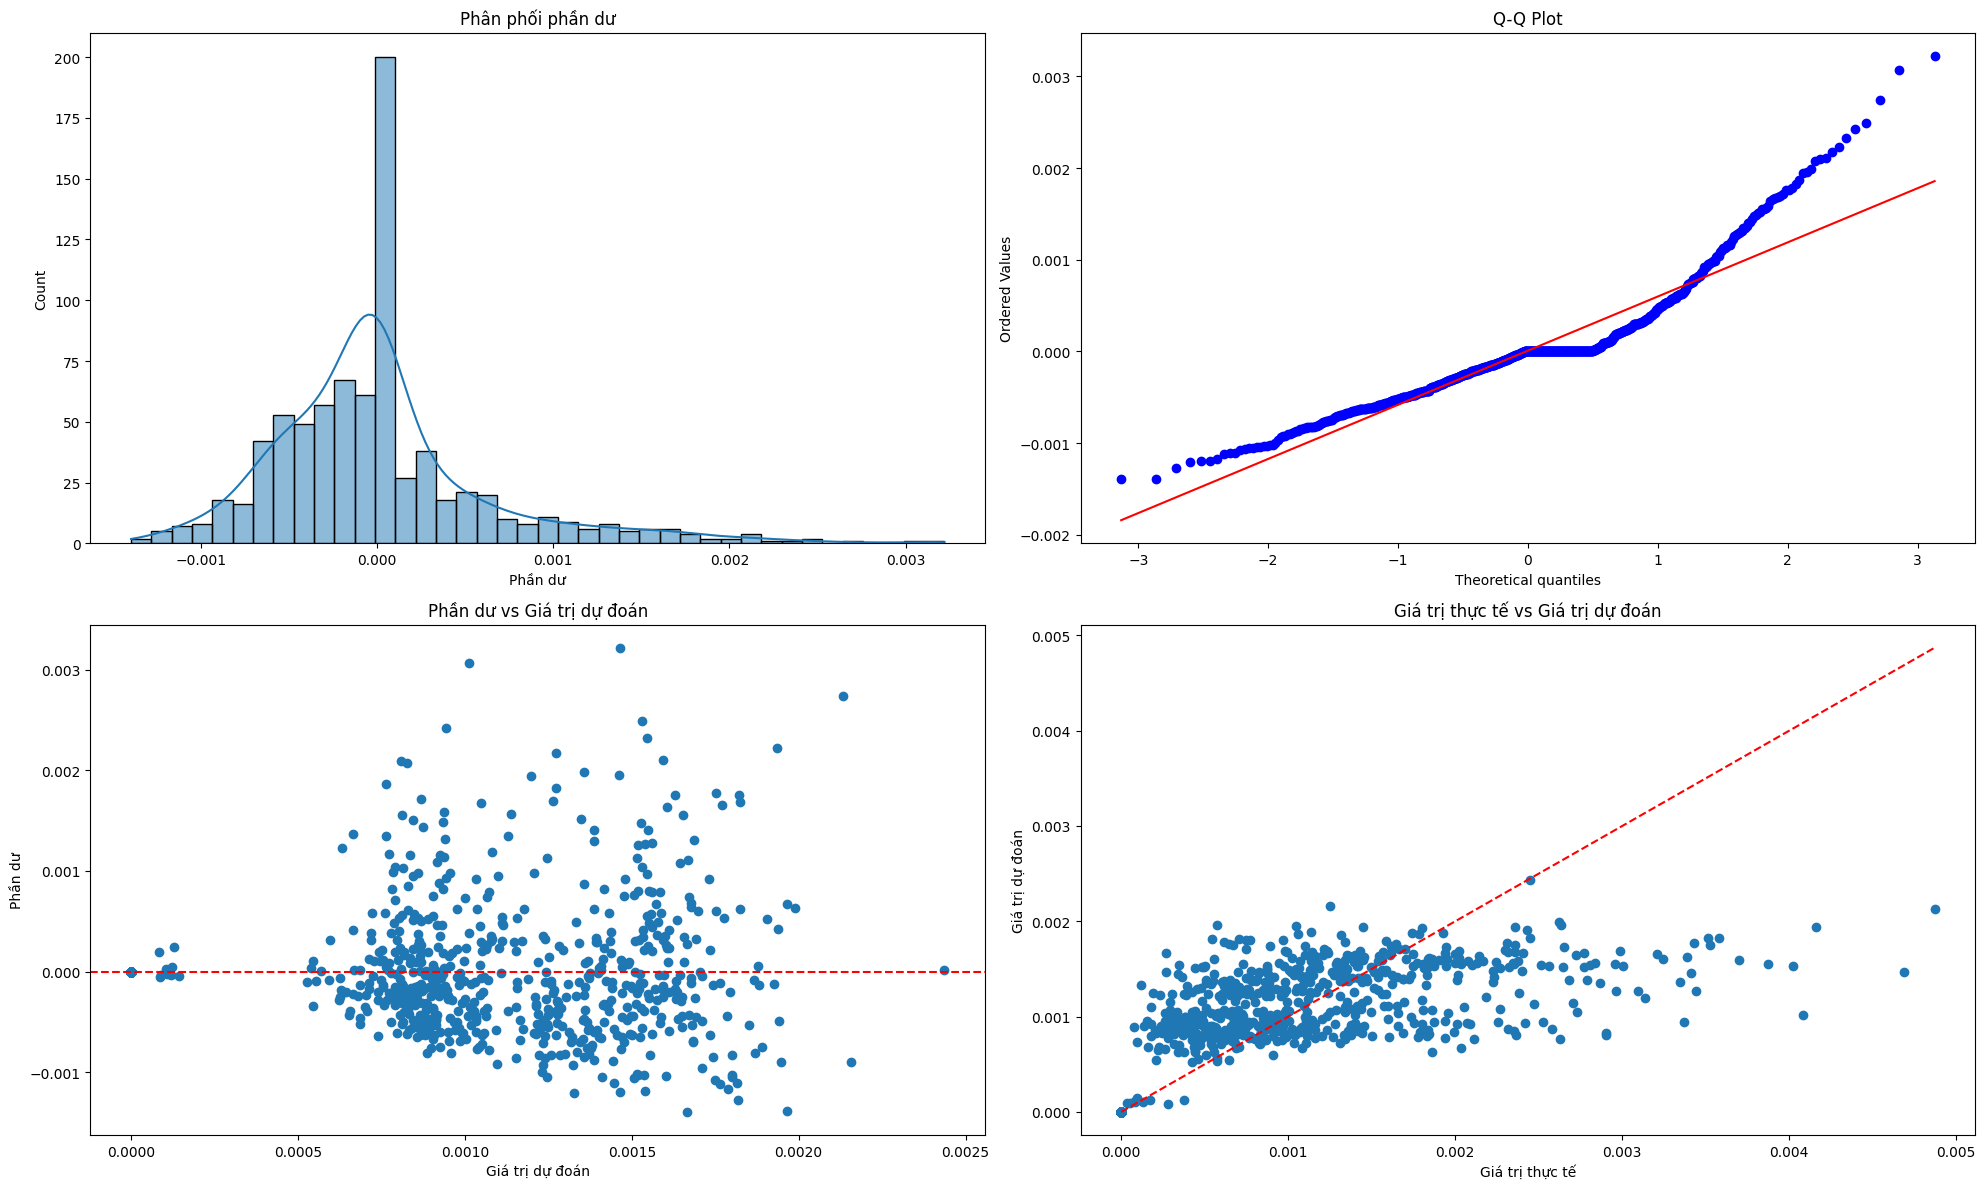

In [ ]:
plt.figure(figsize=(20, 12))
# 5.1. Ph√¢n ph·ªëi ph·∫ßn d∆∞
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Ph√¢n ph·ªëi ph·∫ßn d∆∞')
plt.xlabel('Ph·∫ßn d∆∞')

# 5.2. Q-Q plot
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# 5.3. Scatter plot ph·∫ßn d∆∞ vs gi√° tr·ªã d·ª± ƒëo√°n
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Ph·∫ßn d∆∞ vs Gi√° tr·ªã d·ª± ƒëo√°n')
plt.xlabel('Gi√° tr·ªã d·ª± ƒëo√°n')
plt.ylabel('Ph·∫ßn d∆∞')

# 5.4. Scatter plot gi√° tr·ªã th·ª±c t·∫ø vs gi√° tr·ªã d·ª± ƒëo√°n
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Gi√° tr·ªã th·ª±c t·∫ø vs Gi√° tr·ªã d·ª± ƒëo√°n')
plt.xlabel('Gi√° tr·ªã th·ª±c t·∫ø')
plt.ylabel('Gi√° tr·ªã d·ª± ƒëo√°n')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Shape c·ªßa X_test_final: {X_test_final.shape}")
print(f"Shape c·ªßa y_test: {y_test.shape}")

Shape c·ªßa X_test_final: (797, 146)
Shape c·ªßa y_test: (797,)


In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
# 6. Ki·ªÉm tra ·∫£nh h∆∞·ªüng c·ªßa c√°c ƒëi·ªÉm ngo·∫°i lai

# Reset index ƒë·ªÉ ƒë·∫£m b·∫£o kh·ªõp
X = X_test_final.reset_index(drop=True)
y = y_test.reset_index(drop=True)

# Fit model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Cook's Distance
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

# In ra c√°c ƒëi·ªÉm c√≥ ·∫£nh h∆∞·ªüng m·∫°nh
threshold = 4 / len(y)
influential_points = np.where(cooks_d > threshold)[0]

print("\n=== Cook's Distance ===")
print(f"S·ªë ƒëi·ªÉm c√≥ Cook's D > 4/n: {len(influential_points)}")
print("Ch·ªâ s·ªë c√°c ƒëi·ªÉm ngo·∫°i lai ti·ªÅm nƒÉng:", influential_points)


# 7. Ki·ªÉm ƒë·ªãnh t√≠nh ph√π h·ª£p t·ªïng th·ªÉ
print("\n=== F-test ===")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"p-value: {model.f_pvalue:.4f}")
print(f"K·∫øt lu·∫≠n: {'M√¥ h√¨nh c√≥ √Ω nghƒ©a' if model.f_pvalue < 0.05 else 'M√¥ h√¨nh kh√¥ng c√≥ √Ω nghƒ©a'}")


=== Cook's Distance ===
S·ªë ƒëi·ªÉm c√≥ Cook's D > 4/n: 30
Ch·ªâ s·ªë c√°c ƒëi·ªÉm ngo·∫°i lai ti·ªÅm nƒÉng: [  5  12  22  25  44  95 106 186 195 223 263 273 287 297 300 384 446 460
 468 471 522 528 530 540 555 612 619 733 777 784]

=== F-test ===
F-statistic: 1.4101
p-value: 0.0224
K·∫øt lu·∫≠n: M√¥ h√¨nh c√≥ √Ω nghƒ©a


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:867: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)


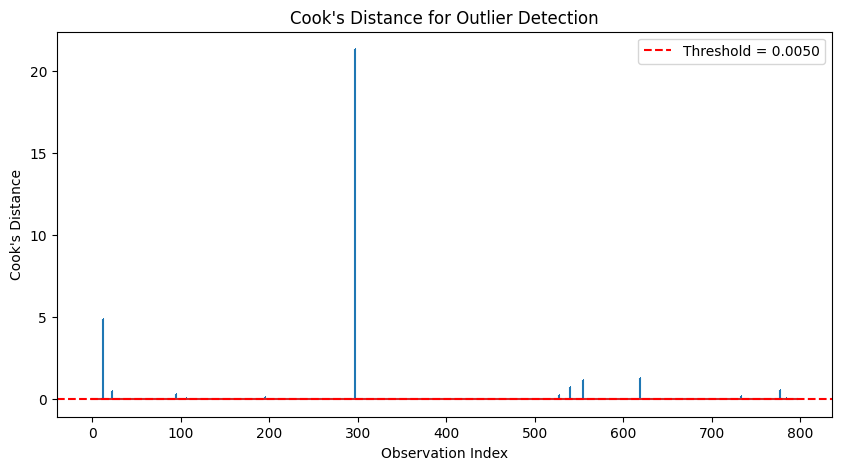

In [ ]:
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Outlier Detection")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# 8. Ki·ªÉm tra t√≠nh ·ªïn ƒë·ªãnh c·ªßa m√¥ h√¨nh (Model Stability)
# Kh·ªüi t·∫°o m√¥ h√¨nh Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Cross-validation v·ªõi scoring l√† R¬≤
scores_r2 = cross_val_score(rf_model, X_test_final, y_test, cv=5, scoring='r2')

print("\n=== K-fold Cross-Validation (R¬≤) ===")
print(f"R¬≤ scores: {scores_r2}")
print(f"Mean R¬≤: {np.mean(scores_r2):.4f}")
print(f"Std R¬≤: {np.std(scores_r2):.4f}")


# T·ª± ƒë·ªãnh nghƒ©a scorer t√≠nh RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# T·∫°o RMSE scorer ƒë√∫ng c√°ch
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # ƒê·∫£o d·∫•u v√¨ RMSE c√†ng th·∫•p c√†ng t·ªët

scores_rmse = cross_val_score(rf_model, X_test_final, y_test, cv=5, scoring=rmse_scorer)

print("\n=== K-fold Cross-Validation (RMSE) ===")
print(f"RMSE scores: {-scores_rmse}")  # ƒê·∫£o l·∫°i d·∫•u ƒë·ªÉ hi·ªán gi√° tr·ªã d∆∞∆°ng
print(f"Mean RMSE: {-np.mean(scores_rmse):.4f}")
print(f"Std RMSE: {np.std(scores_rmse):.4f}")


=== K-fold Cross-Validation (R¬≤) ===
R¬≤ scores: [-0.01387399 -0.16562866 -0.18850169 -0.15866648 -0.32647444]
Mean R¬≤: -0.1706
Std R¬≤: 0.0993

=== K-fold Cross-Validation (RMSE) ===
RMSE scores: [0.00090909 0.00097669 0.00086327 0.00093225 0.000885  ]
Mean RMSE: 0.0009
Std RMSE: 0.0000


In [ ]:
# 9. Ki·ªÉm tra t√≠nh quan tr·ªçng c·ªßa c√°c bi·∫øn (Feature Importance)
# Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest
kd = RandomForestRegressor(n_estimators=100, random_state=42)
kd.fit(X_test_final, y_test)

feature_names = X_test_final.columns
# L·∫•y ƒëi·ªÉm t·∫ßm quan tr·ªçng
importances = kd.feature_importances_
feature_importance = pd.DataFrame({
    'ƒê·∫∑c tr∆∞ng': feature_names,
    'T·∫ßm quan tr·ªçng': importances
}).sort_values(by='T·∫ßm quan tr·ªçng', ascending=False)
print("\n=== T·∫ßm quan tr·ªçng c·ªßa c√°c bi·∫øn ===")
print(feature_importance)


=== T·∫ßm quan tr·ªçng c·ªßa c√°c bi·∫øn ===
                   ƒê·∫∑c tr∆∞ng  T·∫ßm quan tr·ªçng
142    tfidf_Carlo_Ancelotti        0.523275
145            tfidf_b√°n_d·∫´n        0.211549
143              tfidf_Tesla        0.088912
144     tfidf_T√≠n_ch·ªâ_carbon        0.061799
37            posted_hour_20        0.023649
..                       ...             ...
118  tfidf_iPhone_16_Pro_Max        0.000000
135            tfidf_ƒë·∫•u_gi√°        0.000000
132       tfidf_Ti·ªÉu_Long_N·ªØ        0.000000
141         tfidf_th∆∞∆°ng_m·∫°i        0.000000
140          tfidf_h·ªón_chi·∫øn        0.000000

[146 rows x 2 columns]


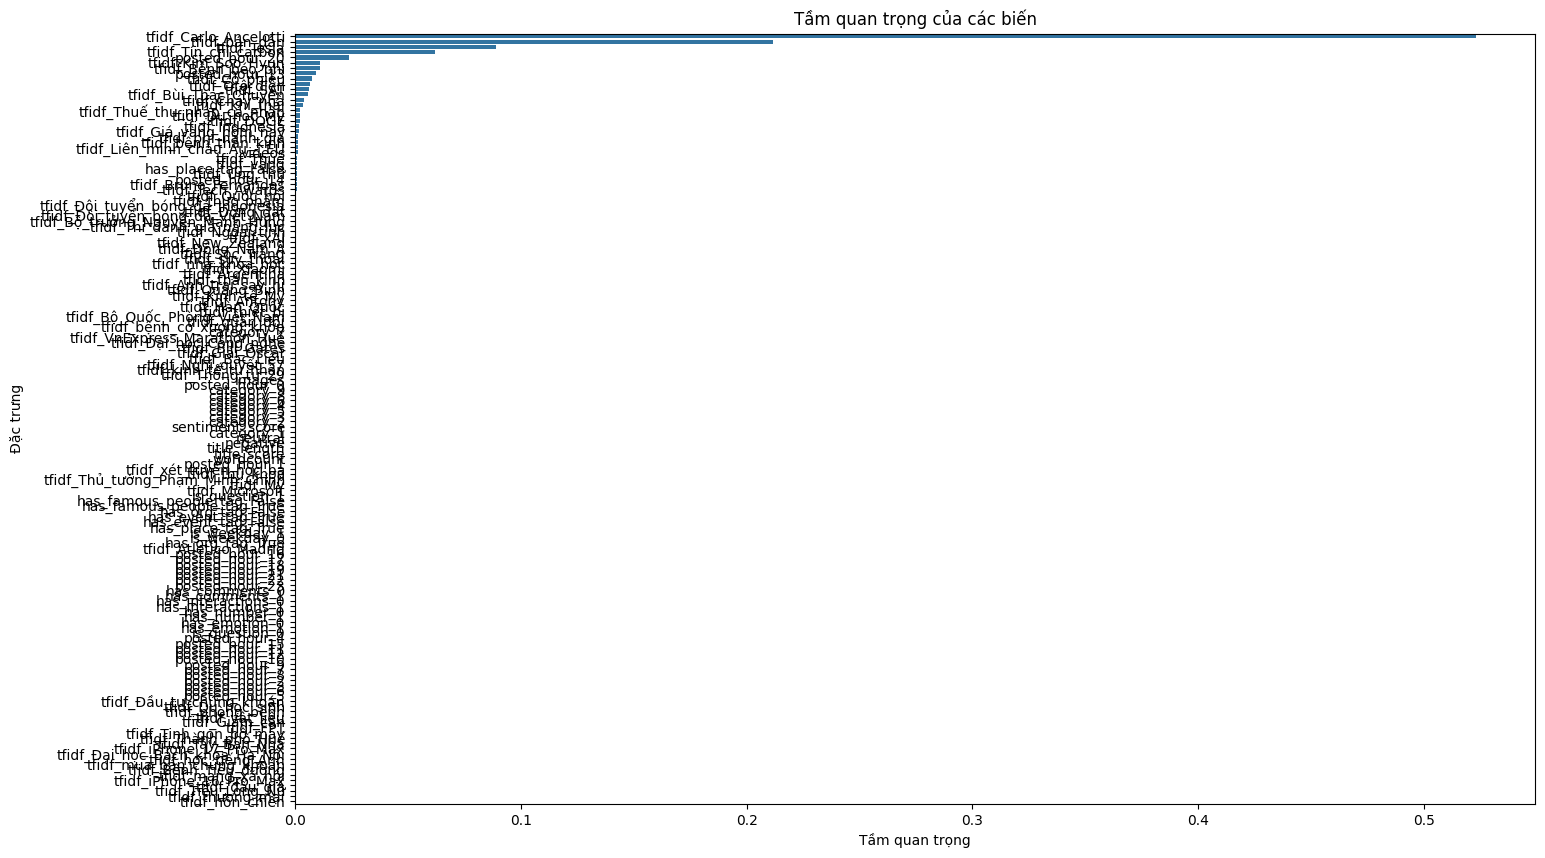

In [ ]:
plt.figure(figsize=(16, 10))
sns.barplot(x='T·∫ßm quan tr·ªçng', y='ƒê·∫∑c tr∆∞ng', data=feature_importance)
plt.title('T·∫ßm quan tr·ªçng c·ªßa c√°c bi·∫øn')
plt.show()

In [ ]:
# 10. Ki·ªÉm ƒë·ªãnh v·ªõi d·ªØ li·ªáu nhi√™u
X_test_noisy = X_test_final + np.random.normal(0, 0.1, X_test_final.shape)
y_pred_noisy = kd.predict(X_test_noisy)
rmse_noisy = np.sqrt(mean_squared_error(y_test, y_pred_noisy))
print(f"\n=== Sensitivity Analysis ===")
print(f"RMSE v·ªõi d·ªØ li·ªáu nhi·ªÖu: {rmse_noisy:.4f}")


=== Sensitivity Analysis ===
RMSE v·ªõi d·ªØ li·ªáu nhi·ªÖu: 0.0007


In [ ]:
# 11. In th√™m c√°c metric ƒë√°nh gi√°
print("\n=== C√ÅC METRIC ƒê√ÅNH GI√Å M√î H√åNH ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R¬≤: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MAE: {np.mean(np.abs(residuals)):.4f}")
print(f"MAPE: {np.mean(np.abs(residuals / y_test)) * 100:.2f}%")
print(f"Gi·∫£i th√≠ch ph∆∞∆°ng sai: {np.var(y_pred) / np.var(y_test):.4f}")


=== C√ÅC METRIC ƒê√ÅNH GI√Å M√î H√åNH ===
RMSE: 0.0006
R¬≤: 0.4452
MAE: 0.0004
MAPE: 67.60%
Gi·∫£i th√≠ch ph∆∞∆°ng sai: 0.4543


## ERROR ANALYSIS

In [ ]:
print(df.columns)

Index(['title', 'date', 'wordcount', 'comments', 'interactions', 'images',
       'videos', 'tags', 'category', 'popularity_score', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'positive', 'negative', 'neutral', 'posted_hour',
       'is_weekday', 'classified_tags', 'has_famous_people_tag',
       'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
       'has_interactions'],
      dtype='object')


In [ ]:
df1 = df

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Log-transform target
y_train_log = np.log1p(y_train)
y_dev_log = np.log1p(y_dev)  # D√πng cho so s√°nh & ƒë·∫£o ng∆∞·ª£c

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# C√°c m√¥ h√¨nh v√† grid parameters
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

best_models = {}
results = {}
error_dfs = []

for model_name, config in models.items():
    print(f"\n--- Hu·∫•n luy·ªán {model_name} ---")

    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Hu·∫•n luy·ªán tr√™n log(target)
    grid.fit(X_train_combined, y_train_log)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # D·ª± ƒëo√°n tr√™n log-scale
    y_dev_pred_log = best_model.predict(X_dev_combined)

    # ƒê·∫£o log-transform
    y_dev_pred = np.expm1(y_dev_pred_log)
    y_dev_true = np.expm1(y_dev_log)

    # T√≠nh RMSE v√† R¬≤ tr√™n d·ªØ li·ªáu g·ªëc
    dev_mse = mean_squared_error(y_dev_true, y_dev_pred)
    dev_rmse = np.sqrt(dev_mse) # Calculate RMSE by taking the square root of MSE

    dev_r2 = r2_score(y_dev_true, y_dev_pred)

    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2
    }

    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (RMSE - log scale): {(-grid.best_score_)**0.5:.4f}")

    print(f"\n{model_name} (best parameters)")

    if model_name == 'Ridge Regression':
        print("H·ªá s·ªë (cho c√°c th√†nh ph·∫ßn ch√≠nh):")
        if hasattr(best_model, 'coef_'):
            for i, coef in enumerate(best_model.coef_):
                print(f"  PC{i+1}: {coef:.4f}")
        else:
            print("  Kh√¥ng c√≥ h·ªá s·ªë (v√≠ d·ª•: m√¥ h√¨nh c√¢y)")
    else:
        print("ƒê·ªô quan tr·ªçng c·ªßa c√°c th√†nh ph·∫ßn ch√≠nh:")
        if hasattr(best_model, 'feature_importances_'):
            for i, importance in enumerate(best_model.feature_importances_):
                print(f"  PC{i+1}: {importance:.4f}")
        else:
            print("  Kh√¥ng c√≥ ƒë·ªô quan tr·ªçng ƒë·∫∑c tr∆∞ng (v√≠ d·ª•: m√¥ h√¨nh tuy·∫øn t√≠nh)")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R¬≤: {dev_r2:.4f}")

    # =========================
    # PH√ÇN T√çCH L·ªñI & L∆ØU CSV
    # =========================
    try:
        if 'ID' in X_dev.columns:
            dev_ids = X_dev['ID'].reset_index(drop=True)
        else:
            dev_ids = y_dev.index.to_series().reset_index(drop=True)

        df_error = pd.DataFrame({
            'ID': dev_ids,
            'y_true': y_dev_true.reset_index(drop=True),
            'y_pred': pd.Series(y_dev_pred),
            'error': pd.Series(y_dev_pred) - y_dev_true.reset_index(drop=True),
        })

        df_error['abs_error'] = np.abs(df_error['error'])
        df_error['model'] = model_name

        # Chuy·ªÉn sparse -> dense n·∫øu c·∫ßn
        X_dev_dense = X_dev_combined.toarray() if hasattr(X_dev_combined, 'toarray') else X_dev_combined

        # Ghi l·∫°i th√†nh ph·∫ßn PCA
        for i in range(X_dev_dense.shape[1]):
            df_error[f'PC{i+1}'] = X_dev_dense[:, i]

        # L∆∞u file l·ªói
        csv_filename = f"errors_{model_name.replace(' ', '_').lower()}.csv"
        df_error.to_csv(csv_filename, index=False)
        print(f"‚úÖ ƒê√£ l∆∞u l·ªói th√†nh file: {csv_filename}")

        error_dfs.append(df_error)

    except Exception as e:
        print(f"‚ö†Ô∏è L·ªói khi x·ª≠ l√Ω v√† l∆∞u df_error cho {model_name}: {e}")


--- Hu·∫•n luy·ªán XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV score (RMSE - log scale): 0.0007

XGBoost Regressor (best parameters)
ƒê·ªô quan tr·ªçng c·ªßa c√°c th√†nh ph·∫ßn ch√≠nh:
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0048
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0000
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0022
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0085
  PC32: 0.0000
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: 0.0024
  PC39: 0.0000
  PC40: 0.0000
  PC41: 0.0000
  PC42: 0.0000
  PC43: 0.0000
  PC44: 0.0000
  PC45: 0.0000
  PC

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

‚úÖ ƒê√£ l∆∞u l·ªói th√†nh file: errors_xgboost_regressor.csv

--- Hu·∫•n luy·ªán Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (RMSE - log scale): 0.0007

Ridge Regression (best parameters)
H·ªá s·ªë (cho c√°c th√†nh ph·∫ßn ch√≠nh):
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0000
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0001
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0001
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0004
  PC32: -0.0001
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: -0.0001
  PC39: 0.0000
  PC40: 0.0000
  PC41: 0.0000
  PC42: 0.0000
  PC43: 0.0000
  PC44: 0.0000
  PC45: 0.0000

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

‚úÖ ƒê√£ l∆∞u l·ªói th√†nh file: errors_ridge_regression.csv

--- Hu·∫•n luy·ªán Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (RMSE - log scale): 0.0007

Random Forest Regressor (best parameters)
ƒê·ªô quan tr·ªçng c·ªßa c√°c th√†nh ph·∫ßn ch√≠nh:
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0001
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0010
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0000
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0059
  PC32: 0.0000
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: 0.0002
  PC39: 0.0000
  PC40: 0.00

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

‚úÖ ƒê√£ l∆∞u l·ªói th√†nh file: errors_random_forest_regressor.csv


In [ ]:
# In k·∫øt qu·∫£ t·ªïng h·ª£p
print("\n--- K·∫øt qu·∫£ t·ªïng h·ª£p tr√™n t·∫≠p Dev ---")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['dev_rmse']:.4f}, R¬≤ = {metrics['dev_r2']:.4f}")


--- K·∫øt qu·∫£ t·ªïng h·ª£p tr√™n t·∫≠p Dev ---
XGBoost Regressor: RMSE = 0.0007, R¬≤ = 0.4300
Ridge Regression: RMSE = 0.0007, R¬≤ = 0.4244
Random Forest Regressor: RMSE = 0.0007, R¬≤ = 0.4285


In [ ]:
# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_xgb = xgb_model.predict(X_test_combined)

# ƒê√°nh gi√°
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb)**0.5)
print("XGBoost - R2 score:", r2_score(y_test, y_pred_xgb))

# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_rf = rf_model.predict(X_test_combined)

# ƒê√°nh gi√°
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf)**0.5)
print("Random Forest - R2 score:", r2_score(y_test, y_pred_rf))

# D√πng m√¥ h√¨nh t·ªët nh·∫•t t·ª´ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# D·ª± ƒëo√°n
y_pred_rr = rr_model.predict(X_test_combined)

# ƒê√°nh gi√°
print("Ridge Regression - RMSE:", mean_squared_error(y_test, y_pred_rr)**0.5)
print("Ridge Regression - R2 score:", r2_score(y_test, y_pred_rr))

XGBoost - RMSE: 0.0006355700460423184
XGBoost - R2 score: 0.44079885245545325
Random Forest - RMSE: 0.0006229371805749164
Random Forest - R2 score: 0.462807775748307
Ridge Regression - RMSE: 0.0006393020747475939
Ridge Regression - R2 score: 0.43421238104003024


In [ ]:
import os

# Li·ªát k√™ t·∫•t c·∫£ file trong th∆∞ m·ª•c hi·ªán t·∫°i
for file in os.listdir():
    if file.endswith('.csv') and file.startswith('errors_'):
        print(file)

errors_xgboost_regressor.csv
errors_ridge_regression.csv
errors_random_forest_regressor.csv


In [ ]:
import os

# T·∫°o th∆∞ m·ª•c m·ªõi tr√™n Google Drive n·∫øu ch∆∞a c√≥
save_dir = '/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited'
os.makedirs(save_dir, exist_ok=True)

import shutil

# Danh s√°ch c√°c file csv b·∫°n ƒë√£ l∆∞u
csv_files = [
    'errors_xgboost_regressor.csv',
    'errors_ridge_regression.csv',
    'errors_random_forest_regressor.csv'
]

# Di chuy·ªÉn t·ª´ng file v√†o th∆∞ m·ª•c tr√™n Drive
for file in csv_files:
    src = f'/content/{file}'  # v·ªã tr√≠ hi·ªán t·∫°i trong Colab
    dst = os.path.join(save_dir, file)  # v·ªã tr√≠ tr√™n Drive
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"ƒê√£ chuy·ªÉn {file} v√†o Google Drive: {dst}")
    else:
        print(f"Kh√¥ng t√¨m th·∫•y file: {file}")

ƒê√£ chuy·ªÉn errors_xgboost_regressor.csv v√†o Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_xgboost_regressor.csv
ƒê√£ chuy·ªÉn errors_ridge_regression.csv v√†o Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_ridge_regression.csv
ƒê√£ chuy·ªÉn errors_random_forest_regressor.csv v√†o Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_random_forest_regressor.csv


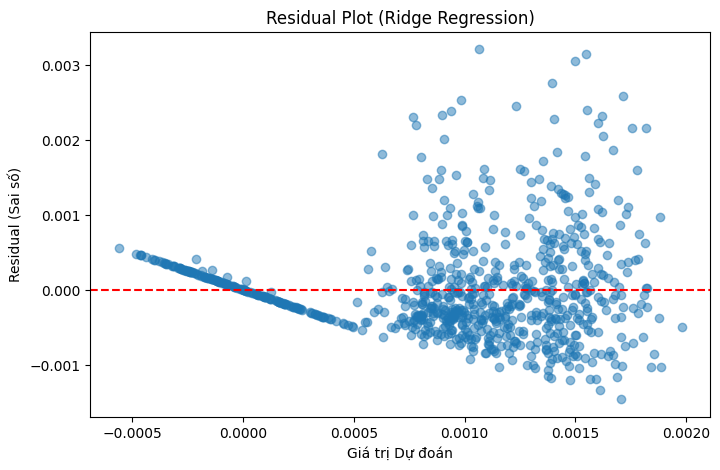

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ƒê·ªçc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# T√≠nh residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# V·∫Ω residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Gi√° tr·ªã D·ª± ƒëo√°n')
plt.ylabel('Residual (Sai s·ªë)')
plt.title('Residual Plot (Ridge Regression)')
plt.show()

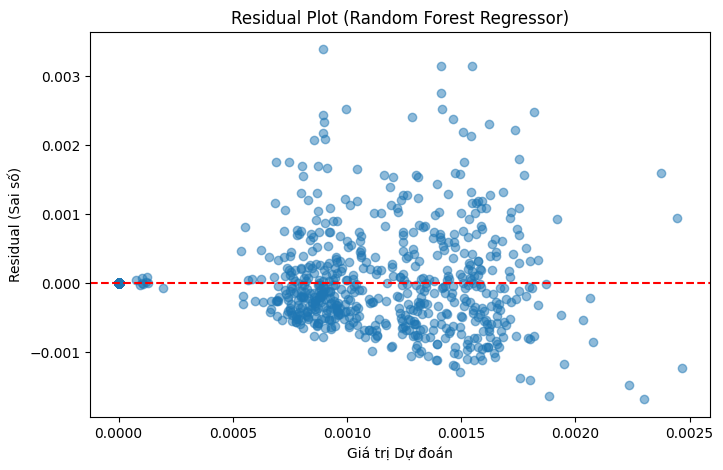

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ƒê·ªçc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# T√≠nh residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# V·∫Ω residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Gi√° tr·ªã D·ª± ƒëo√°n')
plt.ylabel('Residual (Sai s·ªë)')
plt.title('Residual Plot (Random Forest Regressor)')
plt.show()

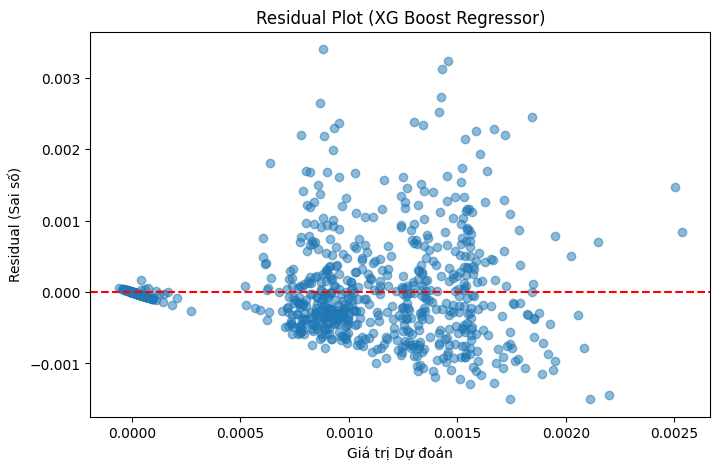

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ƒê·ªçc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# T√≠nh residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# V·∫Ω residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Gi√° tr·ªã D·ª± ƒëo√°n')
plt.ylabel('Residual (Sai s·ªë)')
plt.title('Residual Plot (XG Boost Regressor)')
plt.show()

In [ ]:
import pandas as pd

#-----------------------
#   XGBoost Regressor
#-----------------------

# ƒê·ªçc file l·ªói t·ª´ m√¥ h√¨nh
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# T√≠nh ƒë·ªô sai s·ªë tuy·ªát ƒë·ªëi
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Ch·ªçn top-k l·ªói l·ªõn nh·∫•t
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Ch·ªçn c√°c c·ªôt li√™n quan ƒë·ªÉ ph√¢n t√≠ch
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Th√™m c·ªôt ƒë·ªÉ ghi ch√∫ ph√¢n t√≠ch th·ªß c√¥ng
df_analysis['note'] = ''  # B·∫°n c√≥ th·ªÉ ƒëi·ªÅn sau trong Excel/Google Sheets

# L∆∞u file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv', index=False)

print("ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa XGBoost")

#-----------------------
#   Random Forest
#-----------------------

# ƒê·ªçc file l·ªói t·ª´ m√¥ h√¨nh
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# T√≠nh ƒë·ªô sai s·ªë tuy·ªát ƒë·ªëi
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Ch·ªçn top-k l·ªói l·ªõn nh·∫•t
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Ch·ªçn c√°c c·ªôt li√™n quan ƒë·ªÉ ph√¢n t√≠ch
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Th√™m c·ªôt ƒë·ªÉ ghi ch√∫ ph√¢n t√≠ch th·ªß c√¥ng
df_analysis['note'] = ''  # B·∫°n c√≥ th·ªÉ ƒëi·ªÅn sau trong Excel/Google Sheets

# L∆∞u file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv', index=False)

print("ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa Random Forest")

#-----------------------
#  Ridge Regression
#-----------------------

# ƒê·ªçc file l·ªói t·ª´ m√¥ h√¨nh
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# T√≠nh ƒë·ªô sai s·ªë tuy·ªát ƒë·ªëi
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Ch·ªçn top-k l·ªói l·ªõn nh·∫•t
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Ch·ªçn c√°c c·ªôt li√™n quan ƒë·ªÉ ph√¢n t√≠ch
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Th√™m c·ªôt ƒë·ªÉ ghi ch√∫ ph√¢n t√≠ch th·ªß c√¥ng
df_analysis['note'] = ''  # B·∫°n c√≥ th·ªÉ ƒëi·ªÅn sau trong Excel/Google Sheets

# L∆∞u file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv', index=False)

print("ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa Ridge Regression")

ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa XGBoost
ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa Random Forest
ƒê√£ l∆∞u file ph√¢n t√≠ch l·ªói top-k c·ªßa Ridge Regression


In [ ]:
# G·ªòP D·ªÆ LI·ªÜU

import pandas as pd

# XGBOOST

# ƒê·ªçc d·ªØ li·ªáu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv')

# G·ªôp d·ªØ li·ªáu: gi·ªØ to√†n b·ªô df2, n·ªëi th√™m th√¥ng tin t·ª´ df1 d·ª±a tr√™n c·ªôt 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xu·∫•t ra file k·∫øt qu·∫£
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/xgboost_enriched.csv', index=False)

print("ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: xgboost_enriched.csv")

# RANDOM FOREST

# ƒê·ªçc d·ªØ li·ªáu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv')
# G·ªôp d·ªØ li·ªáu: gi·ªØ to√†n b·ªô df2, n·ªëi th√™m th√¥ng tin t·ª´ df1 d·ª±a tr√™n c·ªôt 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xu·∫•t ra file k·∫øt qu·∫£
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/rf_enriched.csv', index=False)

print("ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: rf_enriched.csv")

# RIDGE REGRESSION

# ƒê·ªçc d·ªØ li·ªáu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv')
# G·ªôp d·ªØ li·ªáu: gi·ªØ to√†n b·ªô df2, n·ªëi th√™m th√¥ng tin t·ª´ df1 d·ª±a tr√™n c·ªôt 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xu·∫•t ra file k·∫øt qu·∫£
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/ridge_enriched.csv', index=False)

print("ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: ridge_enriched.csv")

ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: xgboost_enriched.csv
ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: rf_enriched.csv
ƒê√£ g·ªôp th√¥ng tin t·ª´ df1 v√†o df2 theo ID. File l∆∞u: ridge_enriched.csv


XGBOOST

In [ ]:
from xgboost import XGBRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"üìò Fold {fold}: RMSE = {rmse:.4f} | R¬≤ = {r2:.4f}")
    fold += 1

# T·ªïng k·∫øt sau c√°c fold
print("\nüìä Trung b√¨nh c√°c fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ¬± {np.std(rmse_list):.4f}")
print(f"R¬≤:   {np.mean(r2_list):.4f} ¬± {np.std(r2_list):.4f}")

üìò Fold 1: RMSE = 0.0007 | R¬≤ = 0.4519
üìò Fold 2: RMSE = 0.0007 | R¬≤ = 0.4299
üìò Fold 3: RMSE = 0.0007 | R¬≤ = 0.3896
üìò Fold 4: RMSE = 0.0007 | R¬≤ = 0.4360
üìò Fold 5: RMSE = 0.0006 | R¬≤ = 0.4113

üìä Trung b√¨nh c√°c fold:
RMSE: 0.0007 ¬± 0.0000
R¬≤:   0.4237 ¬± 0.0214


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score # Import necessary metrics if not already imported

# Instantiate the model with the chosen parameters
# (Replace with your best model if you used GridSearchCV to find better ones)
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
)

# Fit the model on the combined training data (PCA + BoW)
model.fit(X_train_combined, y_train)

# Predict on the combined test data (PCA + BoW)
y_pred_test = model.predict(X_test_combined) # Use a new variable name for clarity

# Evaluate the model on the test set (optional, but good practice)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- K·∫øt qu·∫£ tr√™n t·∫≠p Test (XGBoost) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R¬≤: {test_r2:.4f}")


# L·∫•y ID t·ª´ t·∫≠p test (n·∫øu c√≥)
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    # N·∫øu kh√¥ng c√≥ ID, s·ª≠ d·ª•ng index c·ªßa y_test
    test_ids = y_test.index.to_series().reset_index(drop=True)

# T·∫°o DataFrame ph√¢n t√≠ch l·ªói, s·ª≠ d·ª•ng y_pred_test m·ªõi
df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index), # ƒê·∫£m b·∫£o index kh·ªõp
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})

# T√≠nh sai s·ªë tuy·ªát ƒë·ªëi
df_test_error['abs_error'] = df_test_error['error'].abs()

X_test_dense = X_test_combined.toarray()  # Chuy·ªÉn sang numpy array

for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')

# Merge metadata ƒë·ªÉ ph√¢n t√≠ch s√¢u h∆°n
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# L∆∞u file CSV
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_xgboost.csv", index=False)
print("‚úÖ ƒê√£ l∆∞u l·ªói t·∫≠p test v√†o: errors_test_xgboost.csv")


--- K·∫øt qu·∫£ tr√™n t·∫≠p Test (XGBoost) ---
RMSE: 0.0006
R¬≤: 0.4498


<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

‚úÖ ƒê√£ l∆∞u l·ªói t·∫≠p test v√†o: errors_test_xgboost.csv


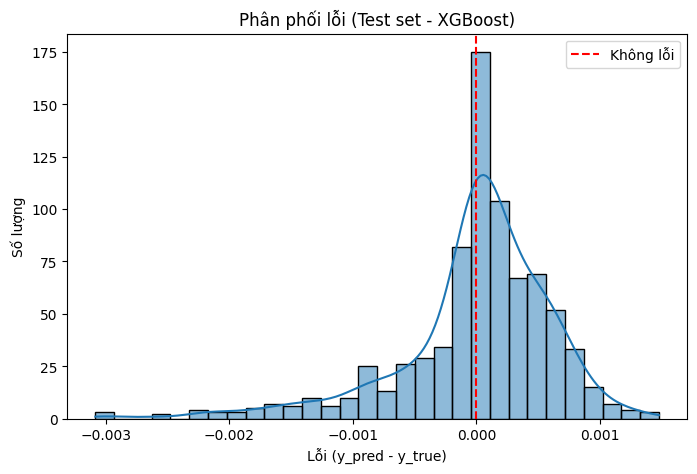

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Ph√¢n ph·ªëi l·ªói (Test set - XGBoost)")
plt.xlabel("L·ªói (y_pred - y_true)")
plt.ylabel("S·ªë l∆∞·ª£ng")
plt.axvline(0, color='red', linestyle='--', label='Kh√¥ng l·ªói')
plt.legend()
plt.show()

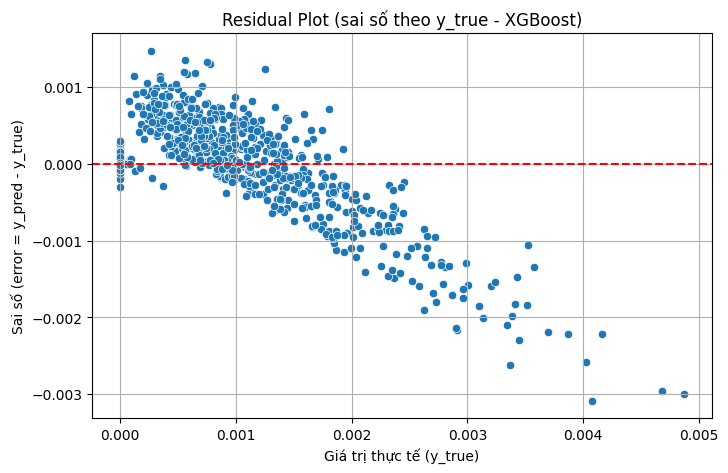

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai s·ªë theo y_true - XGBoost)")
plt.xlabel("Gi√° tr·ªã th·ª±c t·∫ø (y_true)")
plt.ylabel("Sai s·ªë (error = y_pred - y_true)")
plt.grid(True)
plt.show()

RANDOM FOREST

üìò Fold 1: RMSE = 0.0007 | R¬≤ = 0.4546
üìò Fold 2: RMSE = 0.0007 | R¬≤ = 0.4318
üìò Fold 3: RMSE = 0.0007 | R¬≤ = 0.3935
üìò Fold 4: RMSE = 0.0007 | R¬≤ = 0.4452
üìò Fold 5: RMSE = 0.0006 | R¬≤ = 0.4222

üìä Trung b√¨nh c√°c fold:
RMSE: 0.0007 ¬± 0.0000
R¬≤:   0.4295 ¬± 0.0211

--- K·∫øt qu·∫£ tr√™n t·∫≠p Test (Random Forest) ---
RMSE: 0.0006
R¬≤: 0.4662


<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

‚úÖ ƒê√£ l∆∞u l·ªói t·∫≠p test v√†o: errors_test_rf.csv


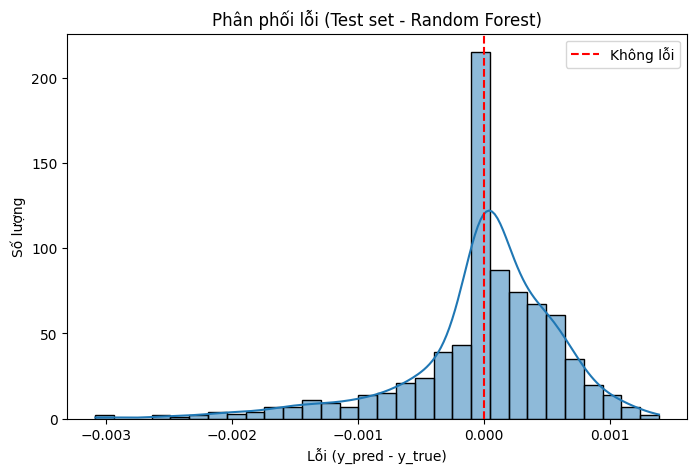

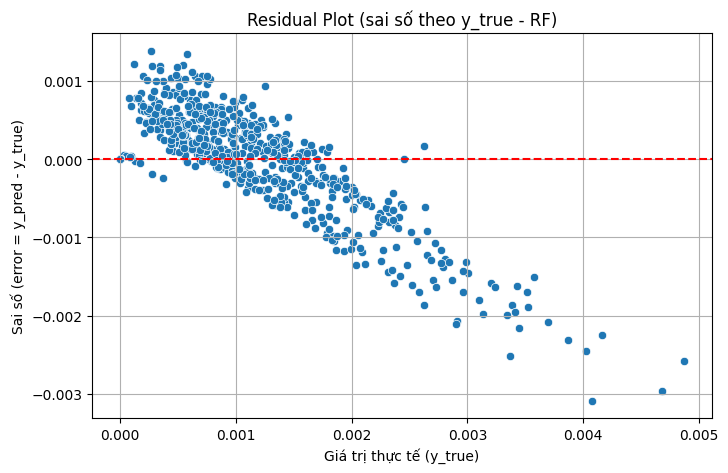

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === CROSS-VALIDATION ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"üìò Fold {fold}: RMSE = {rmse:.4f} | R¬≤ = {r2:.4f}")
    fold += 1

# T·ªïng k·∫øt CV
print("\nüìä Trung b√¨nh c√°c fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ¬± {np.std(rmse_list):.4f}")
print(f"R¬≤:   {np.mean(r2_list):.4f} ¬± {np.std(r2_list):.4f}")

# === TRAIN ON FULL DATA ===
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_combined, y_train)

y_pred_test = model.predict(X_test_combined)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- K·∫øt qu·∫£ tr√™n t·∫≠p Test (Random Forest) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R¬≤: {test_r2:.4f}")

# === PH√ÇN T√çCH L·ªñI ===
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    test_ids = y_test.index.to_series().reset_index(drop=True)

df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index),
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})
df_test_error['abs_error'] = df_test_error['error'].abs()

# Convert sparse to dense for column extraction
X_test_dense = X_test_combined.toarray()

# Add PC1 to PCn columns (d√πng lu√¥n to√†n b·ªô feature t·ª´ PCA + BoW)
for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

# Merge metadata
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# L∆∞u file l·ªói
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_rf.csv", index=False)
print("‚úÖ ƒê√£ l∆∞u l·ªói t·∫≠p test v√†o: errors_test_rf.csv")

# === VISUALIZATION ===
plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Ph√¢n ph·ªëi l·ªói (Test set - Random Forest)")
plt.xlabel("L·ªói (y_pred - y_true)")
plt.ylabel("S·ªë l∆∞·ª£ng")
plt.axvline(0, color='red', linestyle='--', label='Kh√¥ng l·ªói')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai s·ªë theo y_true - RF)")
plt.xlabel("Gi√° tr·ªã th·ª±c t·∫ø (y_true)")
plt.ylabel("Sai s·ªë (error = y_pred - y_true)")
plt.grid(True)
plt.show()